# Outlier_Graph

## 필요 라이브러리 로드

In [520]:
import pandas as pd
import matplotlib.pyplot as plt
import os, math

In [521]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup as bs
import chromedriver_autoinstaller as ca
import random, time

In [522]:
import glob
import shutil

In [445]:
import platform
from matplotlib import font_manager, rc

# 한글 폰트 지정
path = "C:/Windows/Fonts/malgun.ttf"
if platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system()=="Darwin":
    rc('font', family='AppleGothic')
else:
    print("Unknown System")

In [446]:
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False # 그래프에서 음수 표현 가능하도록 설정.

In [447]:
import seaborn as sns

## 파일 불러오기

In [448]:
site_name = 'vibe'

In [449]:
# 기간 설정
start_date = '2022-05-09'
end_date = '2022-05-15'

In [450]:
code_path = 'c:/data/Wantreez/Crawling/music'
code_path

'c:/data/Wantreez/Crawling/music'

## 소속사 입력되지 않은 음원 찾기

In [558]:
site_list = ['flo', 'bugs', 'genie', 'melon', 'vibe']
empty_agency_df = pd.DataFrame()
for site_name in site_list:
    live_folder = f'/crawled_data/mod_{site_name}/'
    path = code_path + live_folder
    file_list = os.listdir(path)
    # 수집한 파일 합치기
    df = pd.DataFrame()
    for one in file_list:
        temp = pd.read_excel(path + one)
        df = pd.concat([df, temp], ignore_index=True)
    df['날짜'] = df['날짜'].astype(str)
    sliced_df = df[(df['날짜'] >= start_date) & (df['날짜'] <= end_date)].reset_index(drop=True)
    temp = sliced_df[sliced_df['소속사'].isna() == True].reset_index(drop=True)
    empty_agency_df = pd.concat([empty_agency_df, temp], ignore_index=True)

In [559]:
empty_agency_df

Empty DataFrame
Columns: [사이트, 날짜, 순위, 곡, 가수, 앨범, 소속사, 소속사_분류]
Index: []

### 수집한 곡의 유니크

In [460]:
len(sliced_df['곡'].unique())

108

In [461]:
dates = pd.date_range(start_date, end_date)
basic_date_df = pd.DataFrame({'날짜':dates})
basic_date_df['날짜'] = basic_date_df['날짜'].astype('str')
basic_date_df

날짜
0  2022-05-09
1  2022-05-10
2  2022-05-11
3  2022-05-12
4  2022-05-13
5  2022-05-14
6  2022-05-15

### 제목과 가수 매칭 값 추출

In [462]:
unique_sliced_df = sliced_df.drop_duplicates(['곡', '가수']).reset_index(drop=True)
unique_sliced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   사이트     114 non-null    object
 1   날짜      114 non-null    object
 2   순위      114 non-null    int64 
 3   곡       114 non-null    object
 4   가수      114 non-null    object
 5   앨범      114 non-null    object
 6   소속사     114 non-null    object
 7   소속사_분류  114 non-null    object
dtypes: int64(1), object(7)
memory usage: 7.2+ KB


### 순위변동 열 추가한 df 생성
* 기본 날짜에 데이터 추가
* nan값 중 곡, 가수, 앨범 명은 해당 가수의 정보로 채우기

In [463]:
song_df_list = []
for i in range(unique_sliced_df.shape[0]):
    temp = unique_sliced_df.iloc[i:i+1, :].reset_index(drop=True)
    one_df = sliced_df[(sliced_df['곡'] == temp['곡'][0]) & (sliced_df['가수'] == temp['가수'][0])].reset_index(drop=True)
    one_df['순위변동'] = - ( one_df['순위'] - one_df['순위'].shift(1) )
    one_df['순위변동'] = one_df['순위변동'].fillna(0)
    one_df['순위변동'] = one_df['순위변동'].astype('int64')
    merged_df = pd.merge(basic_date_df, one_df, how='left', on='날짜')
    site = merged_df['사이트'].value_counts().index[0]
    title = merged_df['곡'].value_counts().index[0]
    artist = merged_df['가수'].value_counts().index[0]
    album = merged_df['앨범'].value_counts().index[0]
    agency = merged_df['소속사'].value_counts().index[0]
    agency_type = merged_df['소속사_분류'].value_counts().index[0]
    merged_df['사이트'] = merged_df['사이트'].fillna(site)
    merged_df['곡'] = merged_df['곡'].fillna(title)
    merged_df['가수'] = merged_df['가수'].fillna(artist)
    merged_df['앨범'] = merged_df['앨범'].fillna(album)
    merged_df['소속사'] = merged_df['소속사'].fillna(agency)
    merged_df['소속사_분류'] = merged_df['소속사_분류'].fillna(agency_type)
    song_df_list.append(merged_df)

In [464]:
merged_df

날짜   사이트    순위       곡   가수      앨범  소속사 소속사_분류  순위변동
0  2022-05-09  Vibe   NaN  안녕이란 말  정승환  안녕이란 말  안테나     기타   NaN
1  2022-05-10  Vibe   NaN  안녕이란 말  정승환  안녕이란 말  안테나     기타   NaN
2  2022-05-11  Vibe   NaN  안녕이란 말  정승환  안녕이란 말  안테나     기타   NaN
3  2022-05-12  Vibe   NaN  안녕이란 말  정승환  안녕이란 말  안테나     기타   NaN
4  2022-05-13  Vibe   NaN  안녕이란 말  정승환  안녕이란 말  안테나     기타   NaN
5  2022-05-14  Vibe   NaN  안녕이란 말  정승환  안녕이란 말  안테나     기타   NaN
6  2022-05-15  Vibe  47.0  안녕이란 말  정승환  안녕이란 말  안테나     기타   0.0

### 노래 개수

In [465]:
len(song_df_list)

114

## 그래프 테스트

### 노래 선택

In [466]:
song_df_list[16].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 0 to 6
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   날짜      7 non-null      object
 1   사이트     7 non-null      object
 2   순위      7 non-null      int64 
 3   곡       7 non-null      object
 4   가수      7 non-null      object
 5   앨범      7 non-null      object
 6   소속사     7 non-null      object
 7   소속사_분류  7 non-null      object
 8   순위변동    7 non-null      int64 
dtypes: int64(2), object(7)
memory usage: 560.0+ bytes


In [467]:
tmp = song_df_list[100]
tmp

날짜   사이트     순위                       곡          가수  \
0  2022-05-09  Vibe    NaN  2step (Feat. Lil Baby)  Ed Sheeran   
1  2022-05-10  Vibe  100.0  2step (Feat. Lil Baby)  Ed Sheeran   
2  2022-05-11  Vibe    NaN  2step (Feat. Lil Baby)  Ed Sheeran   
3  2022-05-12  Vibe    NaN  2step (Feat. Lil Baby)  Ed Sheeran   
4  2022-05-13  Vibe    NaN  2step (Feat. Lil Baby)  Ed Sheeran   
5  2022-05-14  Vibe    NaN  2step (Feat. Lil Baby)  Ed Sheeran   
6  2022-05-15  Vibe    NaN  2step (Feat. Lil Baby)  Ed Sheeran   

                       앨범 소속사 소속사_분류  순위변동  
0  2step (Feat. Lil Baby)  해외     기타   NaN  
1  2step (Feat. Lil Baby)  해외     기타   0.0  
2  2step (Feat. Lil Baby)  해외     기타   NaN  
3  2step (Feat. Lil Baby)  해외     기타   NaN  
4  2step (Feat. Lil Baby)  해외     기타   NaN  
5  2step (Feat. Lil Baby)  해외     기타   NaN  
6  2step (Feat. Lil Baby)  해외     기타   NaN

In [468]:
tmp['곡'].value_counts().index.values[0]

'2step (Feat. Lil Baby)'

In [469]:
tmp['가수'].value_counts().index.values[0]

'Ed Sheeran'

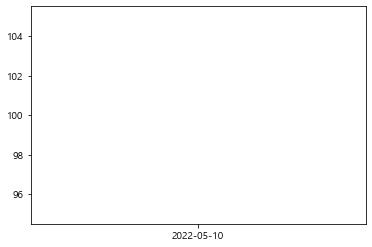

In [470]:
plt.plot(tmp['날짜'], tmp['순위'])

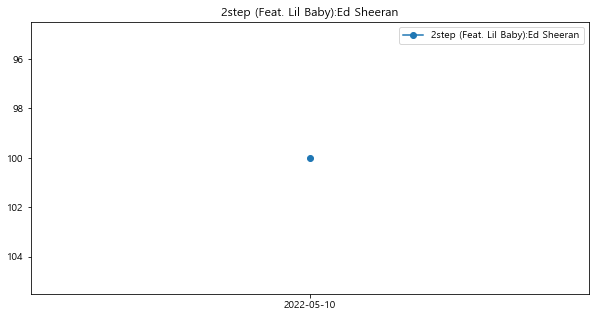

In [471]:
title = tmp['곡'].value_counts().index.values[0]
artist = tmp['가수'].value_counts().index.values[0]
song_label = title + ':' + artist

plt.figure(figsize=(10,5))
ax = plt.axes()
ax.invert_yaxis()
plt.plot(tmp['날짜'], tmp['순위'], '-o', label=song_label)
plt.title(song_label)
plt.legend()
plt.show()

In [472]:
temp_df = song_df_list[70:91]

### 그래프

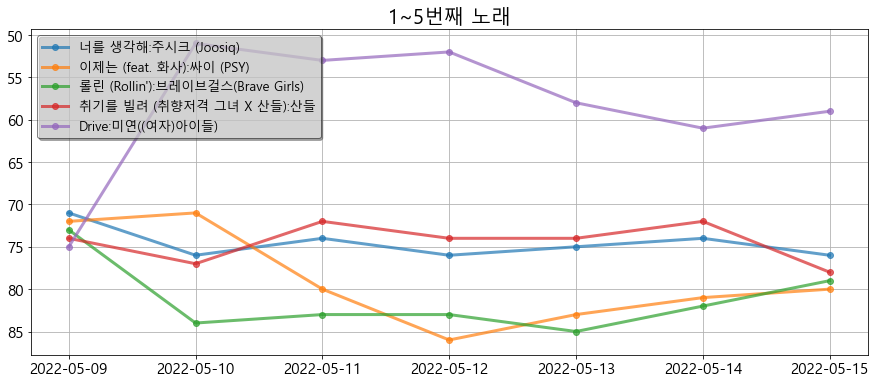

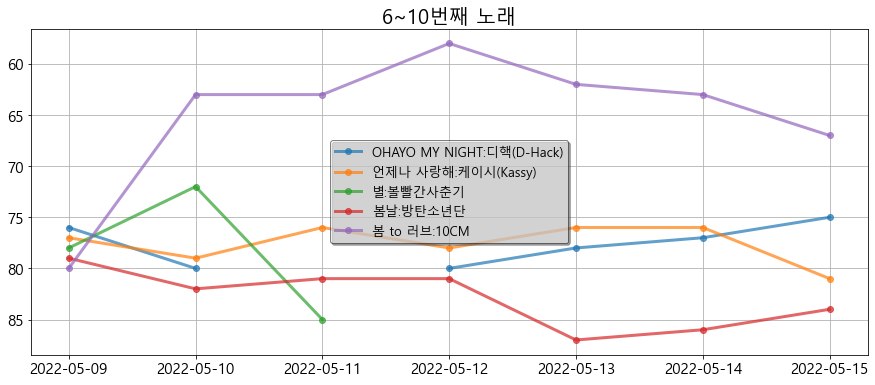

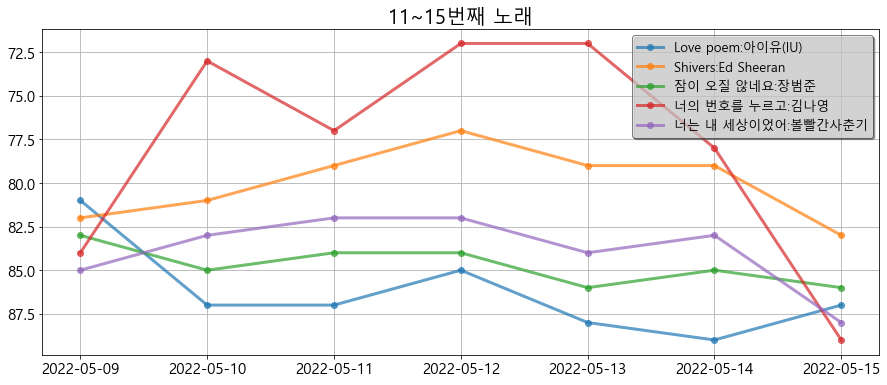

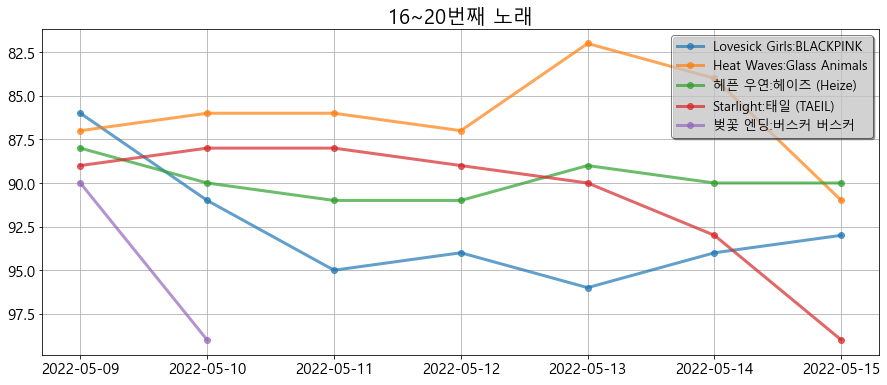

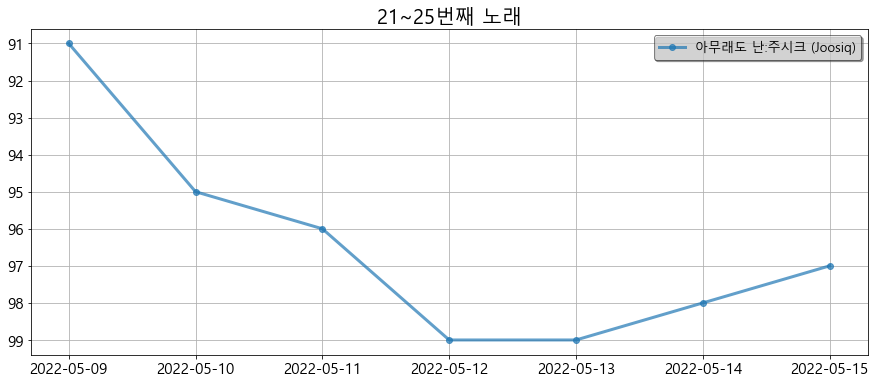

In [473]:
number = 5
t = 0
for i in range( math.ceil(len(temp_df)/number) ):
    plt.figure( figsize=(15, 6) )
    ax = plt.axes()
    ax.invert_yaxis()
    graph_df = temp_df[i*number:(i+1)*number]
    for one in graph_df:
        title = one['곡'].value_counts().index.values[0]
        artist = one['가수'].value_counts().index.values[0]
        song_label = title + ':' + artist
        plt.plot(one['날짜'], one['순위'], '-o', label=song_label, alpha=0.7, linewidth=3)
    t =  t + number
    plt.grid(True)
    plt.title(f'{t-(number-1)}~{t}번째 노래', fontdict={'size':20})
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(framealpha=0.5, frameon=True, shadow=True, edgecolor='k', fontsize=13)
    plt.show()

## 몇 개씩 묶어서 노래 시각화

### 순위 그래프

In [474]:
code_path

'c:/data/Wantreez/Crawling/music'

In [475]:
save_folder = f'/crawled_data/outlier_data/{start_date}_{end_date}/{site_name}/'
save_folder

'/crawled_data/outlier_data/2022-05-09_2022-05-15/vibe/'

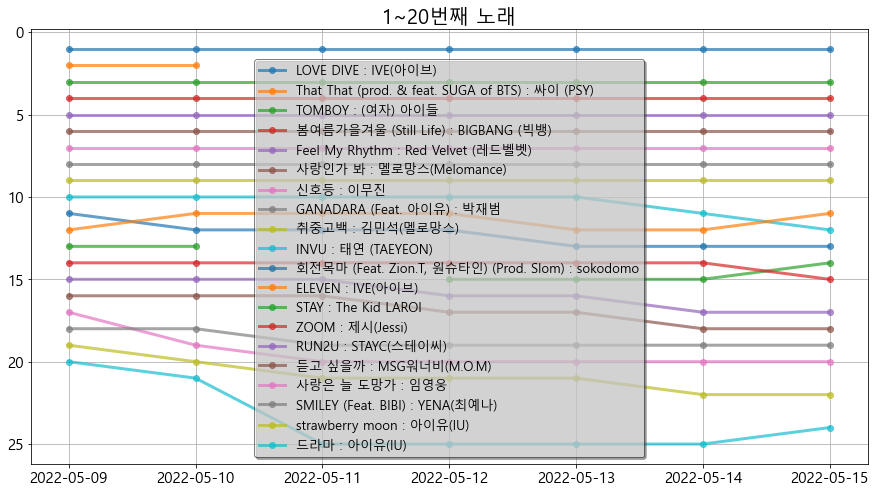

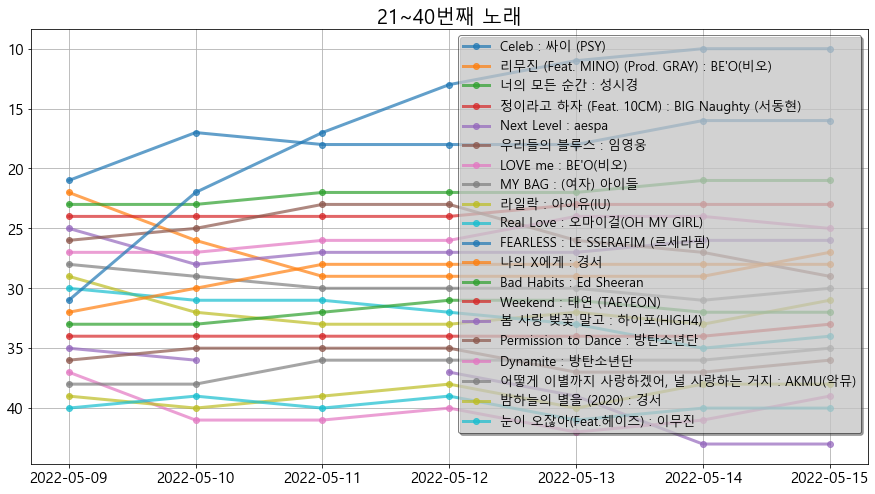

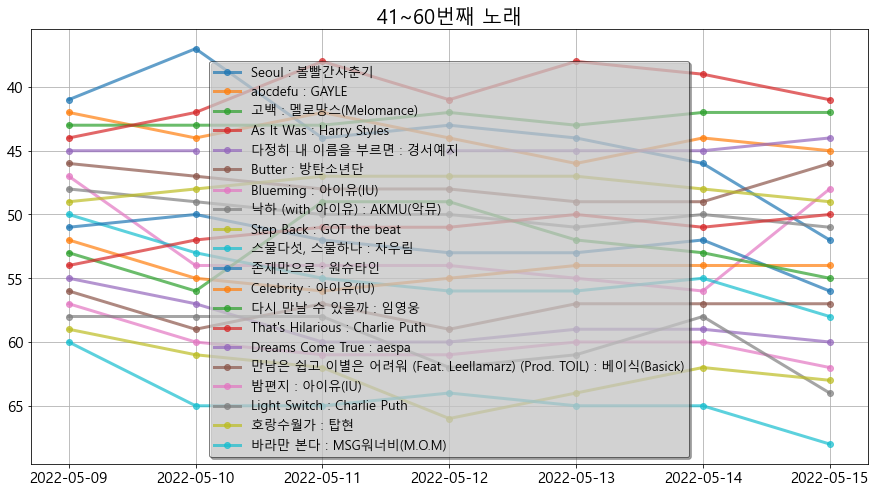

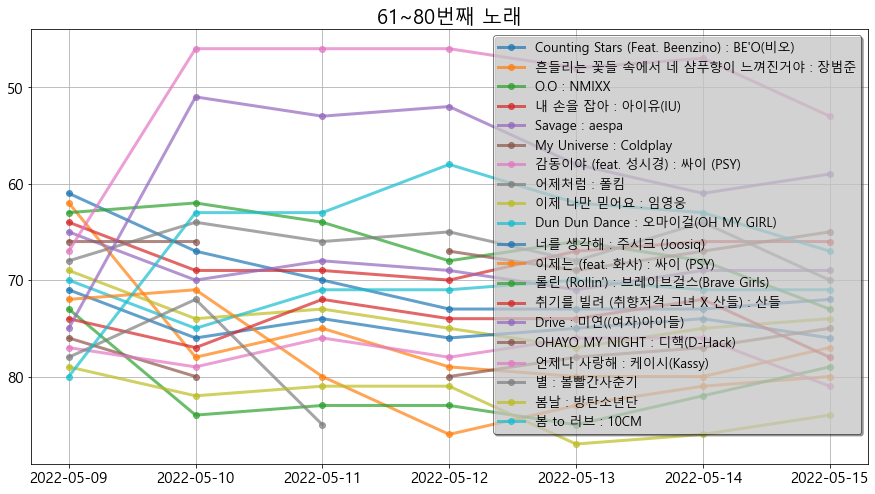

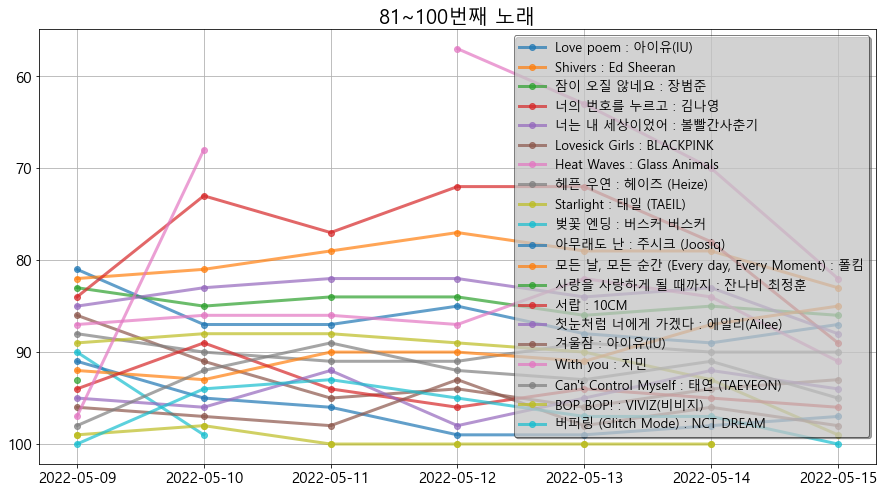

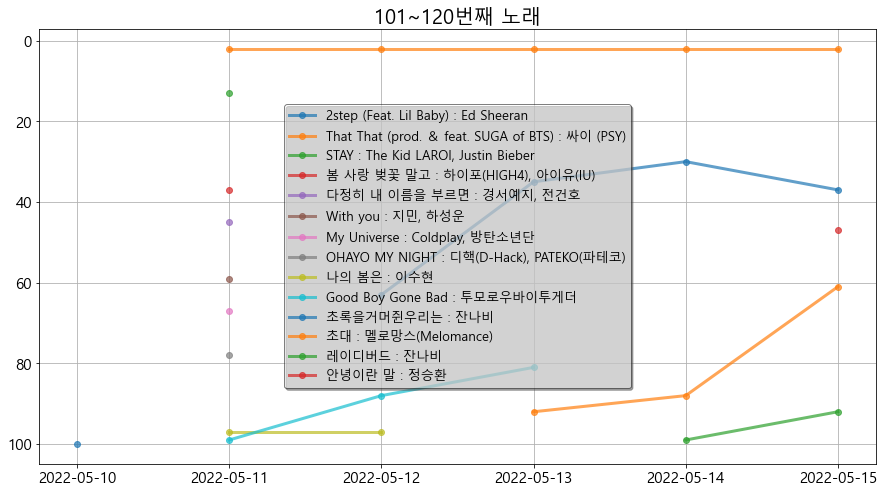

In [476]:
number = 20
t = 0
for i in range( math.ceil(len(song_df_list)/number) ):
    plt.figure( figsize=(15, 8) )
    ax = plt.axes()
    ax.invert_yaxis()
    graph_df = song_df_list[i*number:(i+1)*number]
    for one in graph_df:
        title = one['곡'].value_counts().index.values[0]
        artist = one['가수'].value_counts().index.values[0]
        song_label = title + ' : ' + artist
        plt.plot(one['날짜'], one['순위'], '-o', label=song_label, linewidth=3, alpha=0.7)
    t =  t + number
    plt.grid(True)
    plt.title(f'{t-(number-1)}~{t}번째 노래', fontdict={'size':20})
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(framealpha=0.5, fontsize=13, frameon=True, edgecolor='k', shadow=True);
    plt.savefig(code_path + save_folder + f'[{site_name}]{start_date}_{end_date}_그래프{t:0>2}.png')

## 급등 음원 추출

### 모든 곡 데이터 병합

In [477]:
total_df = pd.DataFrame()
for one in song_df_list:
    total_df = pd.concat([total_df, one], ignore_index=True)

In [478]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      804 non-null    object 
 1   사이트     804 non-null    object 
 2   순위      706 non-null    float64
 3   곡       804 non-null    object 
 4   가수      804 non-null    object 
 5   앨범      804 non-null    object 
 6   소속사     804 non-null    object 
 7   소속사_분류  804 non-null    object 
 8   순위변동    706 non-null    float64
dtypes: float64(2), object(7)
memory usage: 56.7+ KB


### 유일한 곡, 가수 만 남기기

In [479]:
total_df.sort_values(['사이트', '곡', '가수', '순위']).reset_index(drop=True).iloc[80:85, :]

날짜   사이트    순위                 곡           가수  \
80  2022-05-11  Vibe  60.0  Dreams Come True        aespa   
81  2022-05-12  Vibe  60.0  Dreams Come True        aespa   
82  2022-05-15  Vibe  60.0  Dreams Come True        aespa   
83  2022-05-10  Vibe  51.0             Drive  미연((여자)아이들)   
84  2022-05-12  Vibe  52.0             Drive  미연((여자)아이들)   

                               앨범   소속사 소속사_분류  순위변동  
80  Dreams Come True - SM STATION    SM     SM  -3.0  
81  Dreams Come True - SM STATION    SM     SM   0.0  
82  Dreams Come True - SM STATION    SM     SM  -1.0  
83                             MY  CUBE     기타  24.0  
84                             MY  CUBE     기타   1.0

In [480]:
unique_music_df = total_df.sort_values(['사이트', '곡', '가수', '순위']).reset_index(drop=True).drop_duplicates(['곡', '가수'], ignore_index=True)
unique_music_df

날짜   사이트     순위                                       곡  \
0    2022-05-10  Vibe  100.0                  2step (Feat. Lil Baby)   
1    2022-05-11  Vibe   38.0                               As It Was   
2    2022-05-10  Vibe   98.0                                BOP BOP!   
3    2022-05-12  Vibe   31.0                              Bad Habits   
4    2022-05-09  Vibe   47.0                                Blueming   
..          ...   ...    ...                                     ...   
109  2022-05-09  Vibe    9.0                                    취중고백   
110  2022-05-09  Vibe   88.0                                   헤픈 우연   
111  2022-05-09  Vibe   59.0                                   호랑수월가   
112  2022-05-09  Vibe   11.0  회전목마 (Feat. Zion.T, 원슈타인) (Prod. Slom)   
113  2022-05-09  Vibe   62.0                흔들리는 꽃들 속에서 네 샴푸향이 느껴진거야   

               가수                                  앨범         소속사 소속사_분류  순위변동  
0      Ed Sheeran              2step (Feat. Lil Baby)          해외     기타   0.0  
1    Harry Styles                           As It Was          해외     기타   4.0  
2      VIVIZ(비비지)  The 1st Mini Album 'Beam Of Prism'     빅플래닛메이드     기타   1.0  
3      Ed Sheeran                                   0          해외     기타   1.0  
4         아이유(IU)                           Love poem        EDAM     기타   0.0  
..            ...                                 ...         ...    ...   ...  
109     김민석(멜로망스)                                취중고백       ABYSS     기타   0.0  
110   헤이즈 (Heize)                              HAPPEN    P NATION     기타   0.0  
111            탑현                               호랑수월가          개인     기타   0.0  
112      sokodomo                  쇼미더머니 10 Episode 2  SONY MUSIC     기타   0.0  
113           장범준                   멜로가 체질 OST Part 3          개인     기타   0.0  

[114 rows x 9 columns]

In [481]:
mean_unique_music_df = pd.DataFrame()
for i in range(unique_music_df.shape[0]):
    # 특정 곡, 가수 음원 중 순위변동이 양수인 df 추출
    title = unique_music_df['곡'][i]
    artist = unique_music_df['가수'][i]
    temp = total_df[ (total_df['곡'] == title) & (total_df['가수'] == artist) & (total_df['순위변동'] > 0)].reset_index(drop=True)
    # 해당 음원의 순위변동평균
    temp['순위변동평균(양수)'] = round( temp['순위변동'].mean(), 1 )
    # 해당 음원 df의 첫째 줄만 추출
    first_temp = temp.iloc[0:1, :]
    mean_unique_music_df = pd.concat([mean_unique_music_df, first_temp], ignore_index=True)

In [482]:
mean_unique_music_df

날짜   사이트    순위                         곡            가수  \
0   2022-05-10  Vibe  42.0                 As It Was  Harry Styles   
1   2022-05-10  Vibe  98.0                  BOP BOP!    VIVIZ(비비지)   
2   2022-05-11  Vibe  32.0                Bad Habits    Ed Sheeran   
3   2022-05-15  Vibe  48.0                  Blueming       아이유(IU)   
4   2022-05-15  Vibe  46.0                    Butter         방탄소년단   
..         ...   ...   ...                       ...           ...   
79  2022-05-13  Vibe  35.0                 초록을거머쥔우리는           잔나비   
80  2022-05-11  Vibe  72.0     취기를 빌려 (취향저격 그녀 X 산들)            산들   
81  2022-05-13  Vibe  89.0                     헤픈 우연   헤이즈 (Heize)   
82  2022-05-13  Vibe  64.0                     호랑수월가            탑현   
83  2022-05-11  Vibe  75.0  흔들리는 꽃들 속에서 네 샴푸향이 느껴진거야           장범준   

                                    앨범       소속사 소속사_분류  순위변동  순위변동평균(양수)  
0                            As It Was        해외     기타   2.0         3.0  
1   The 1st Mini Album 'Beam Of Prism'   빅플래닛메이드     기타   1.0         1.0  
2                                    0        해외     기타   1.0         1.0  
3                            Love poem      EDAM     기타   8.0         8.0  
4                               Butter       빅히트    빅히트   3.0         3.0  
..                                 ...       ...    ...   ...         ...  
79              잔나비 소곡집 ll : 초록을거머쥔우리는     페포니뮤직     기타  28.0        16.5  
80               취기를 빌려 (취향저격 그녀 X 산들)        WM     기타   5.0         3.5  
81                              HAPPEN  P NATION     기타   2.0         2.0  
82                               호랑수월가        개인     기타   2.0         2.0  
83                   멜로가 체질 OST Part 3        개인     기타   3.0         3.0  

[84 rows x 10 columns]

### 급등 음원 추출

In [483]:
u_outlier = 30
outlier_df = mean_unique_music_df[mean_unique_music_df['순위변동평균(양수)'] > u_outlier].reset_index(drop=True)
outlier_df

Empty DataFrame
Columns: [날짜, 사이트, 순위, 곡, 가수, 앨범, 소속사, 소속사_분류, 순위변동, 순위변동평균(양수)]
Index: []

In [484]:
mod_start_date = start_date.replace('-','')
mod_end_date = end_date.replace('-','')

path = f'C:/data/Wantreez/Crawling/music/crawled_data/outlier_data/{start_date}_{end_date}/{site_name}/'
os.makedirs(path, exist_ok=True)

In [485]:
# 이상치 곡 평균 df 출력
outlier_df.to_excel(path + f'[{site_name}]{mod_start_date}_{mod_end_date}_mean_outliers.xlsx', index=False)
print(f'[{site_name}]{mod_start_date}_{mod_end_date}_mean_outliers.xlsx 출력')

[vibe]20220509_20220515_mean_outliers.xlsx 출력


##### 그래프

In [76]:
import seaborn as sns

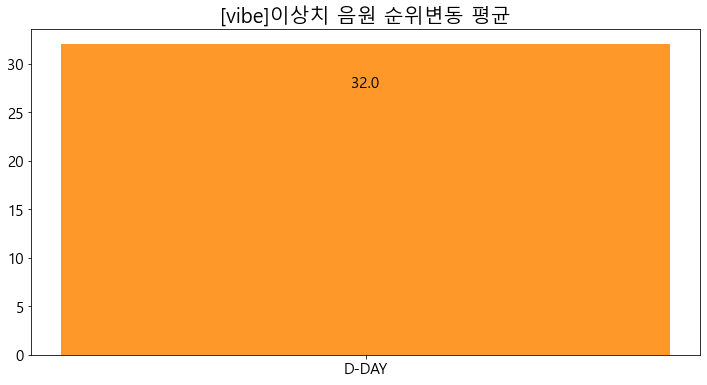

In [82]:
plt.figure(figsize=(12, 6))
colors = sns.color_palette('YlOrBr', outlier_df.shape[0])
plt.bar('곡', '순위변동평균(양수)', data=outlier_df, color=colors, width=0.5)
plt.title(f'[{site_name}]이상치 음원 순위변동 평균', fontdict={'size':20})
for i in range(outlier_df.shape[0]):
    plt.text(i, outlier_df['순위변동평균(양수)'][i] - outlier_df['순위변동평균(양수)'].max()*0.1, round(outlier_df['순위변동평균(양수)'][i], 1), verticalalignment='top', horizontalalignment='center', fontsize=15)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15);

## 이상치 음원 순위 변동 그래프

[flo]20220509_20220515_mean_outliers.xlsx 출력
[bugs]20220509_20220515_mean_outliers.xlsx 출력


C:\Users\kbjung\AppData\Local\Temp/ipykernel_15120/3580881751.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure( figsize=(15, 8) )


[genie]20220509_20220515_mean_outliers.xlsx 출력
[melon]20220509_20220515_mean_outliers.xlsx 출력
[vibe]20220509_20220515_mean_outliers.xlsx 출력


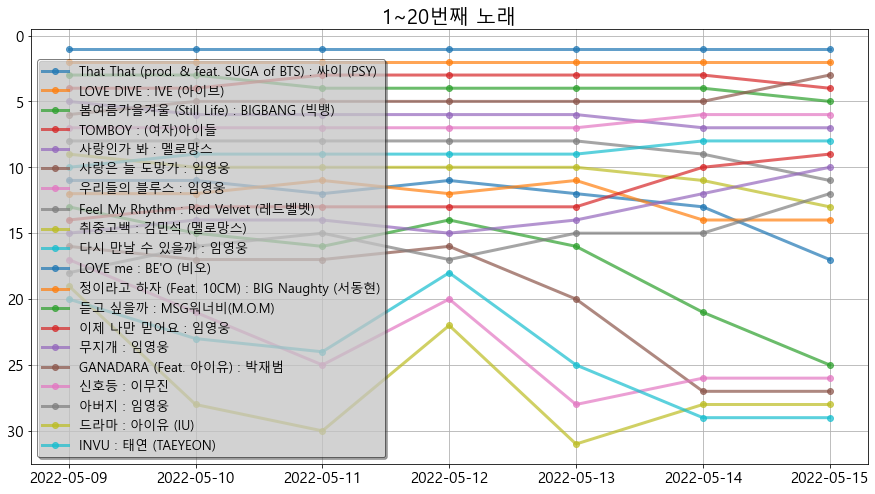

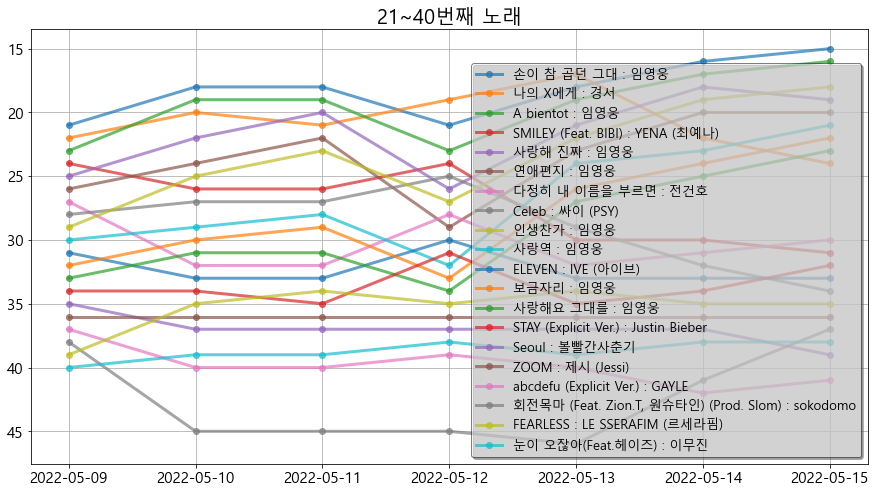

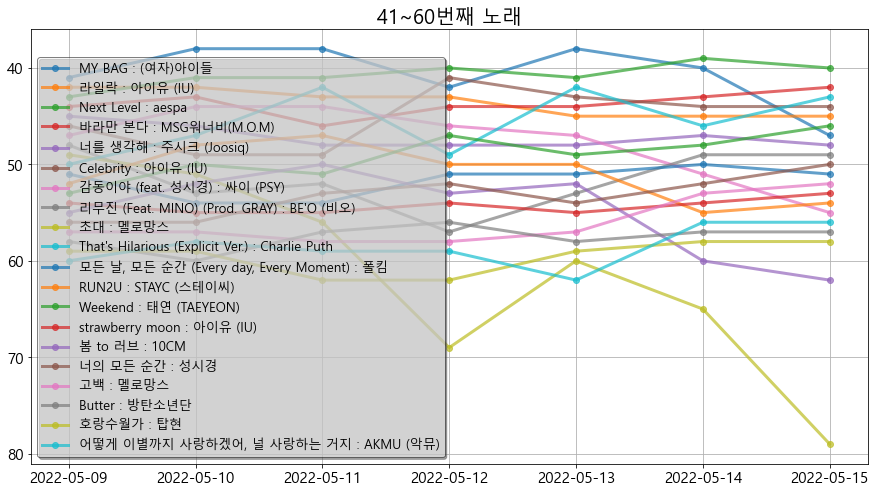

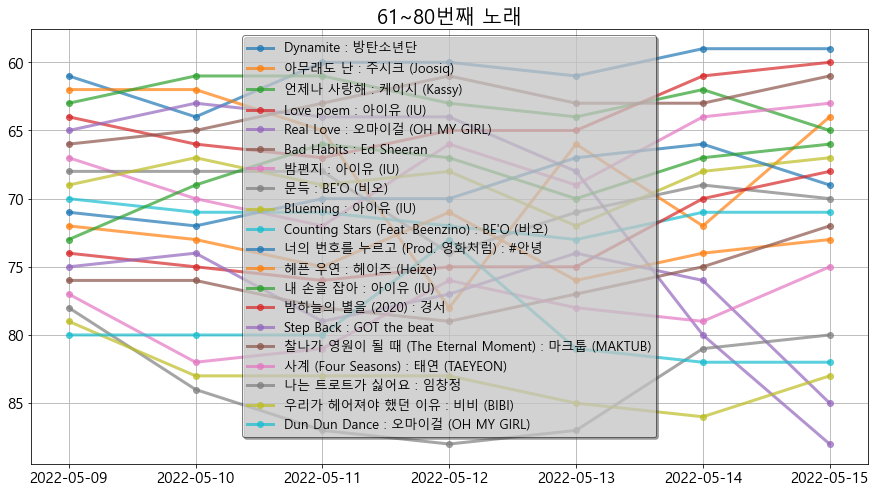

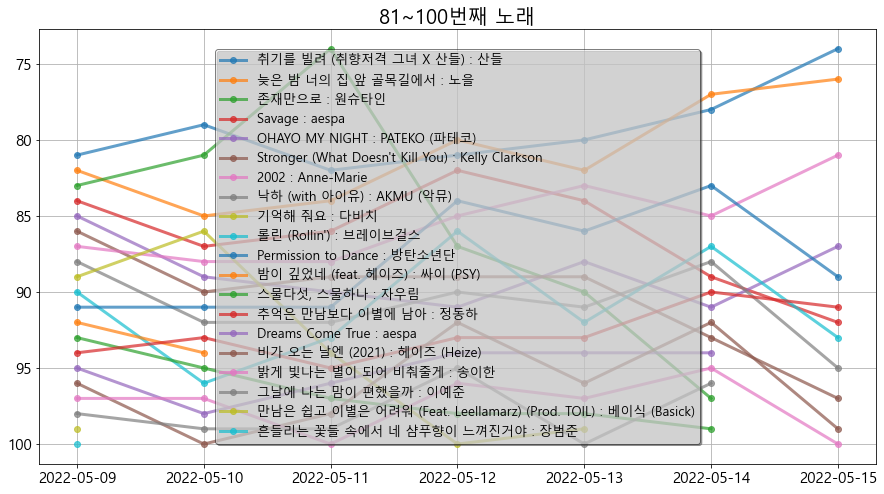

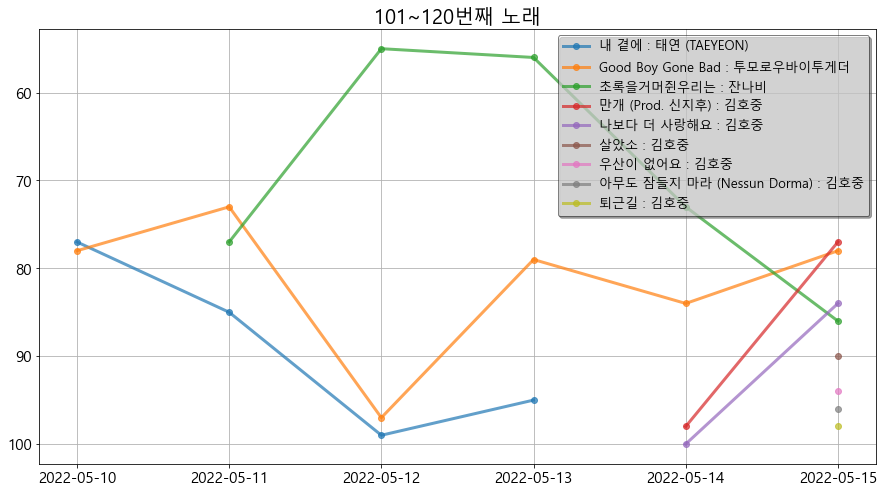

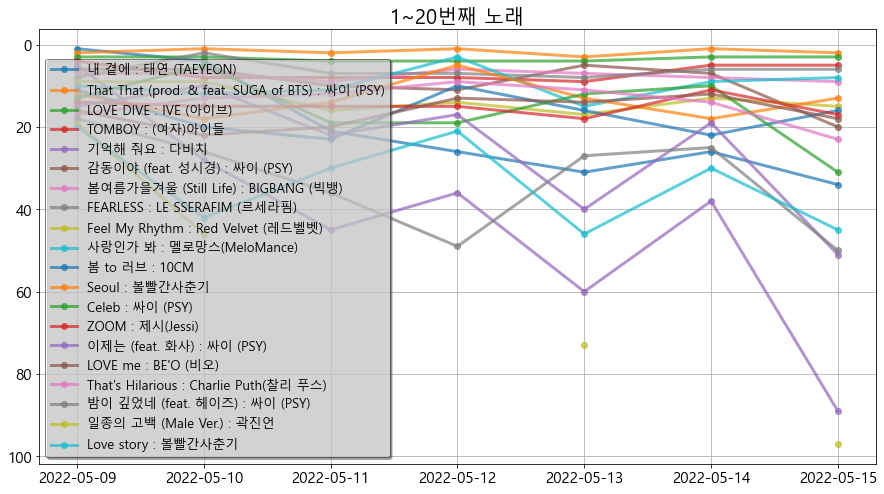

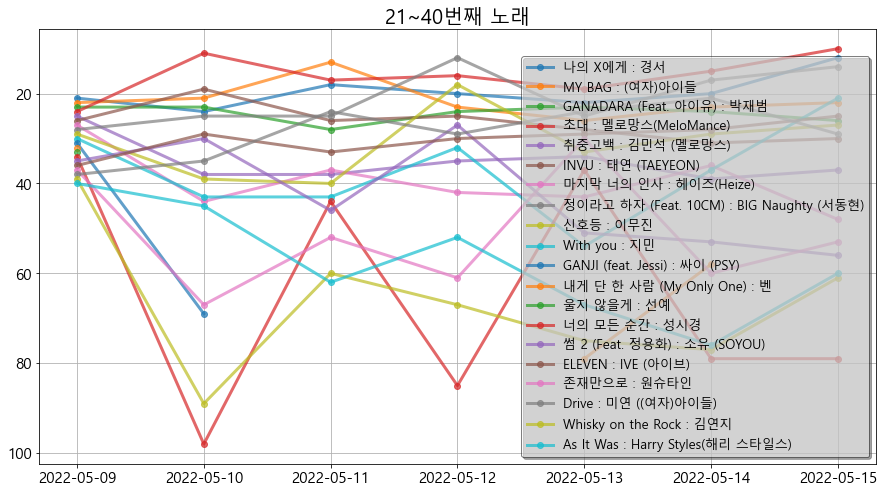

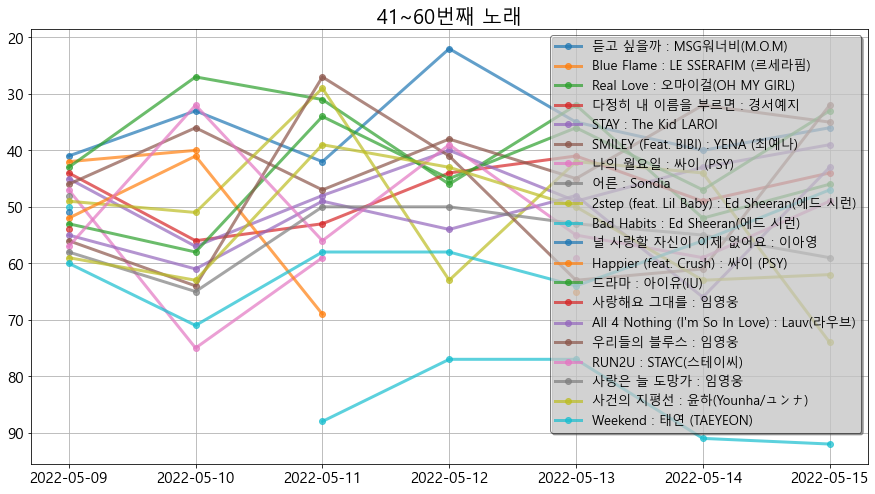

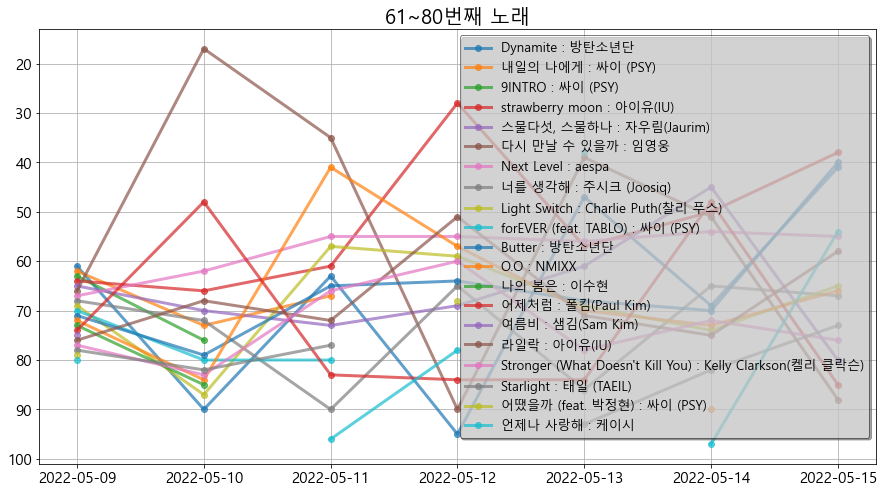

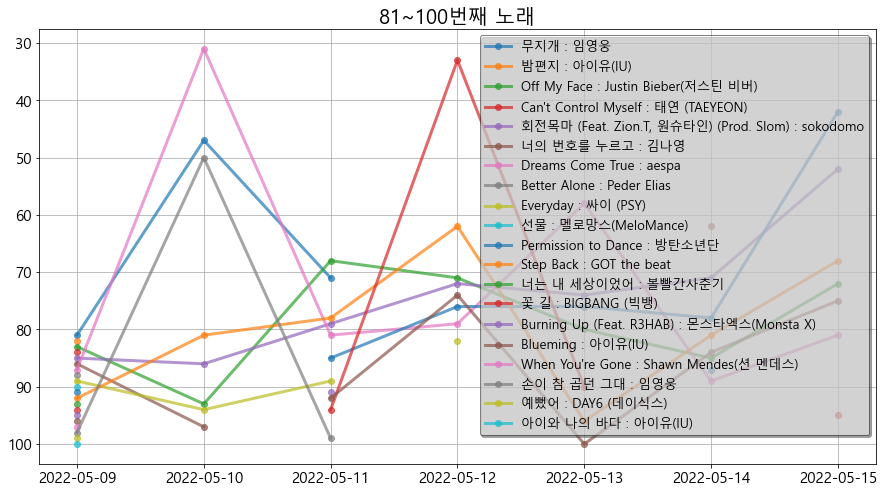

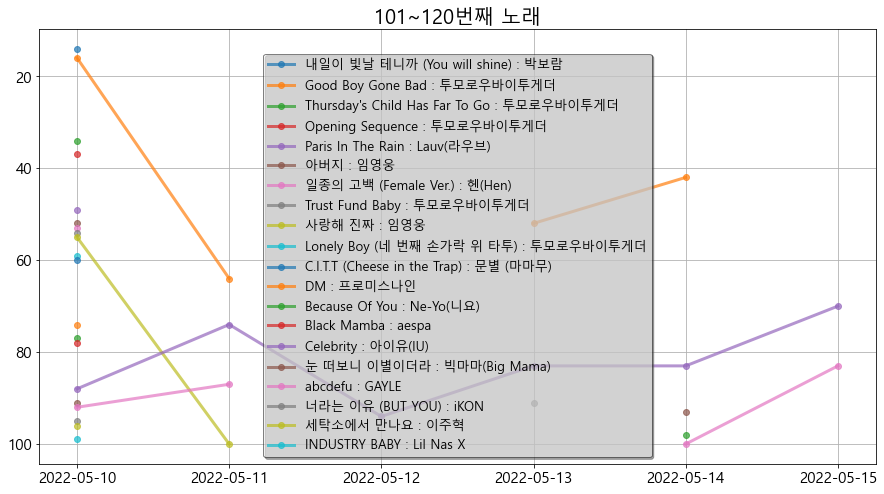

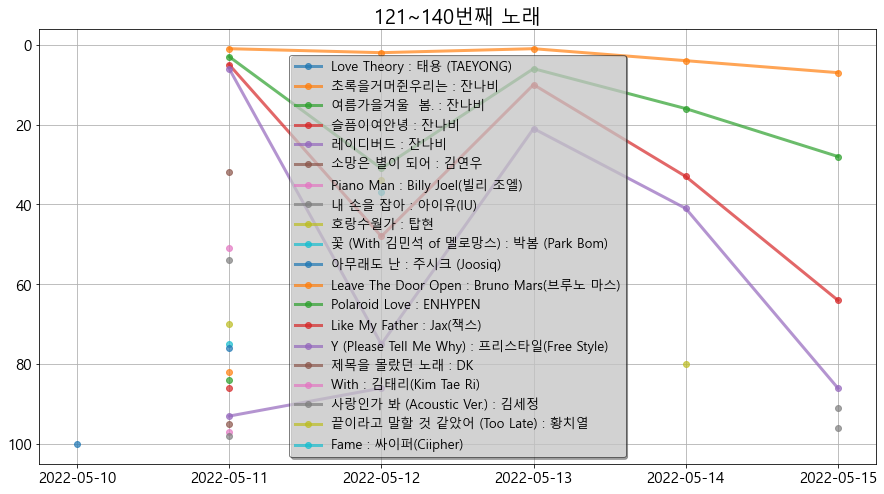

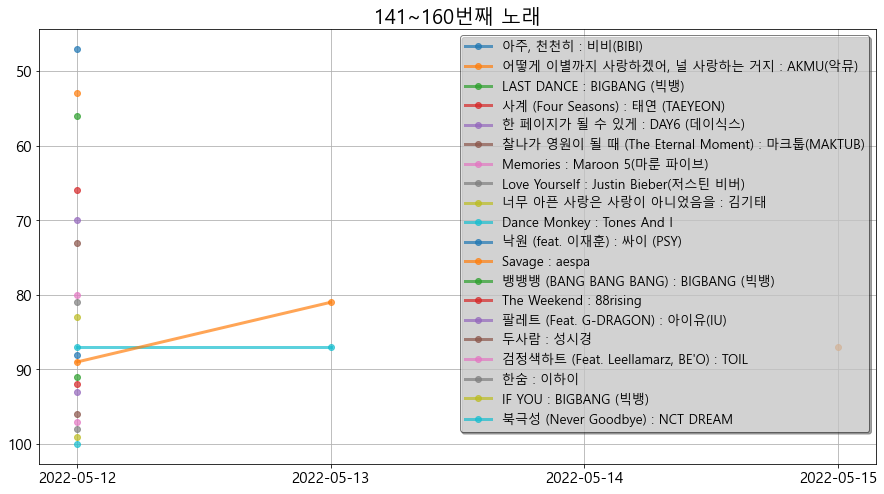

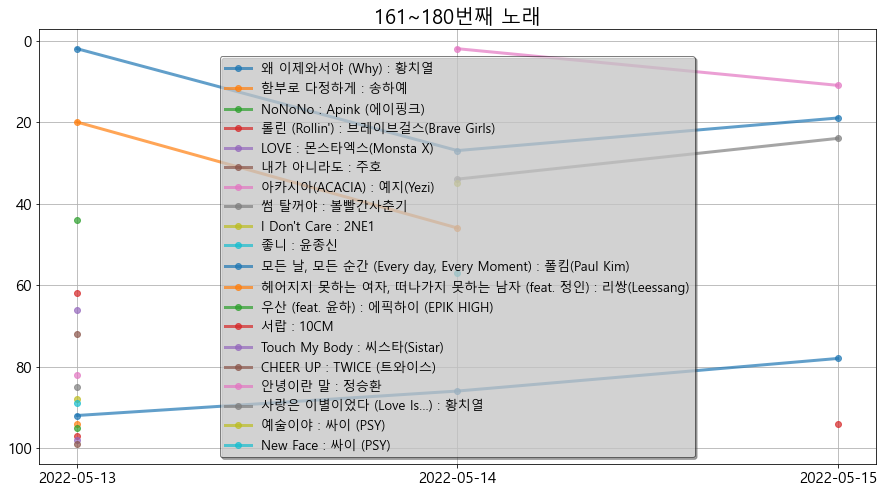

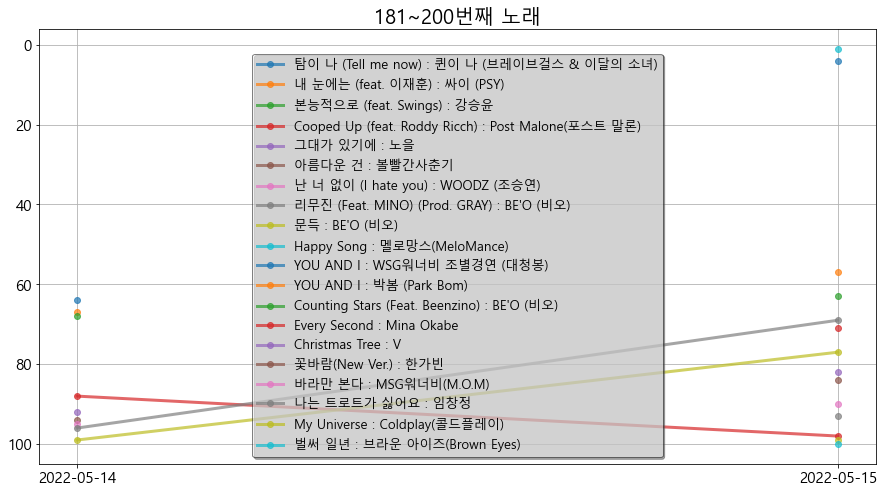

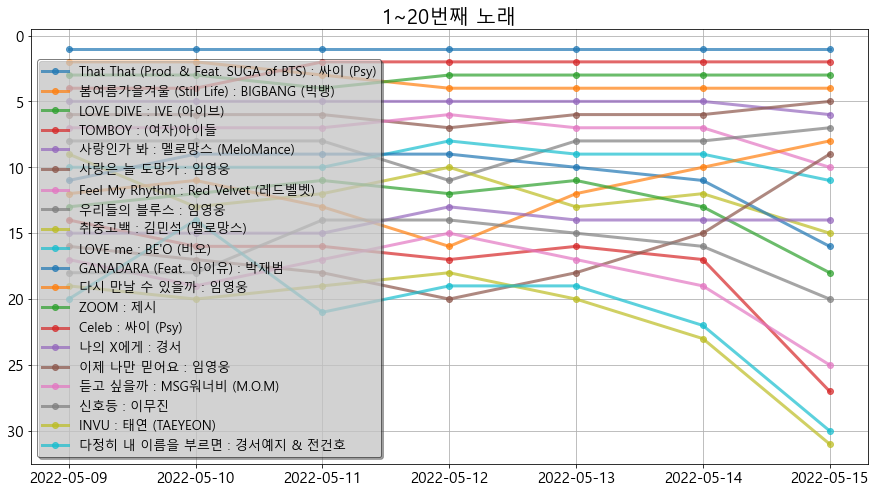

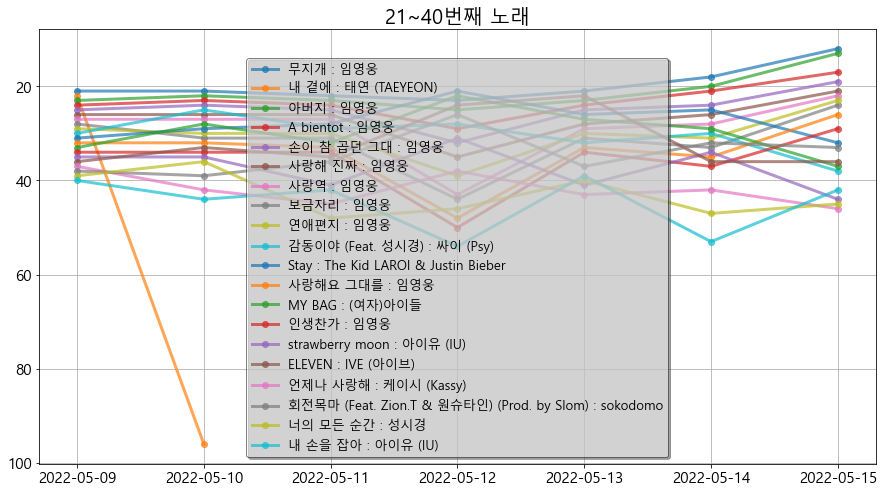

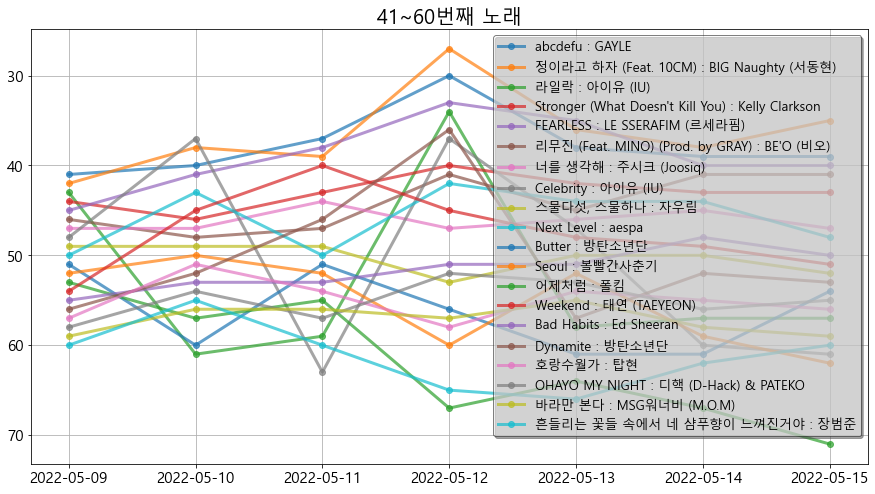

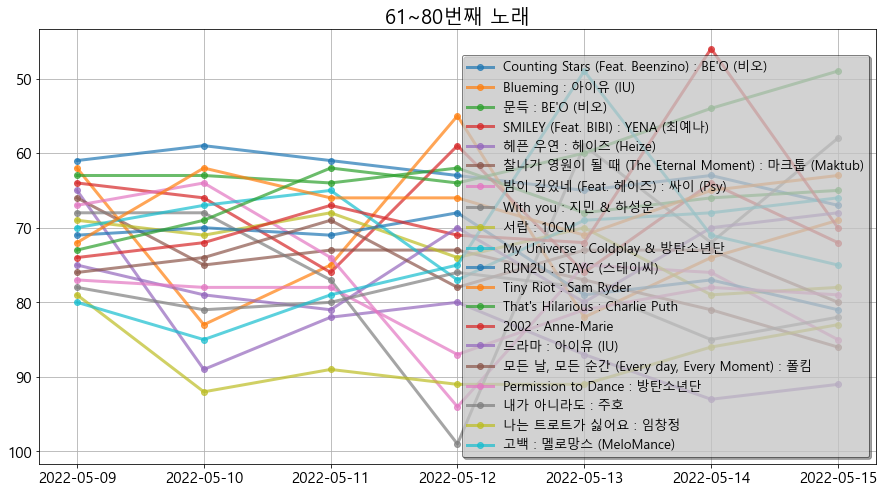

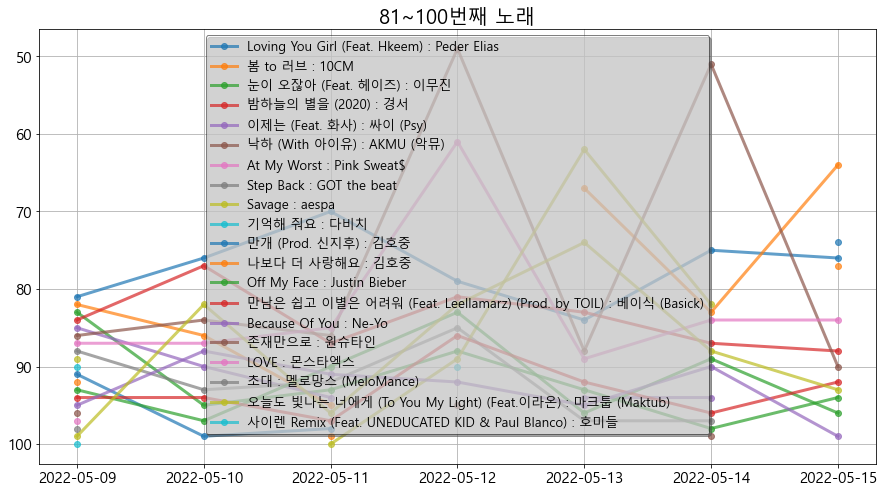

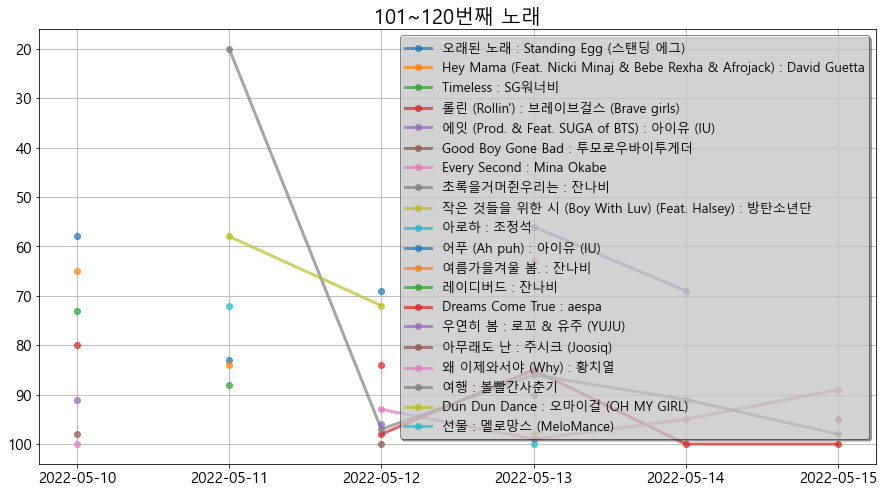

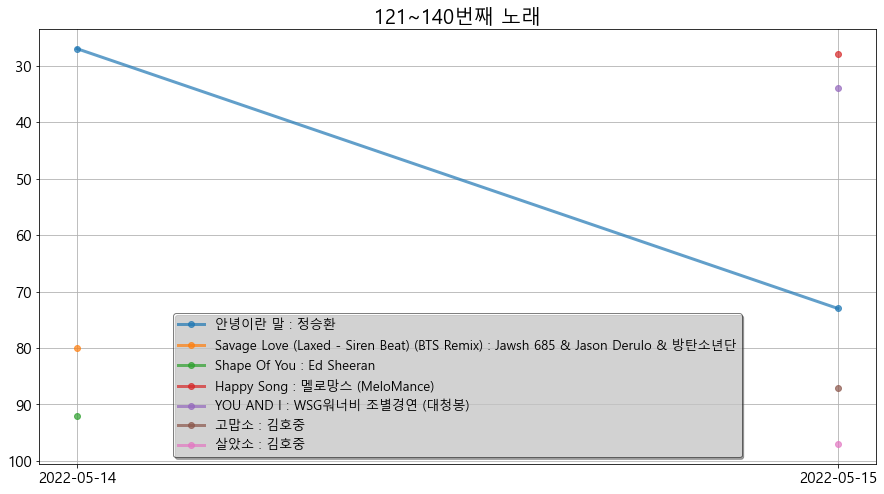

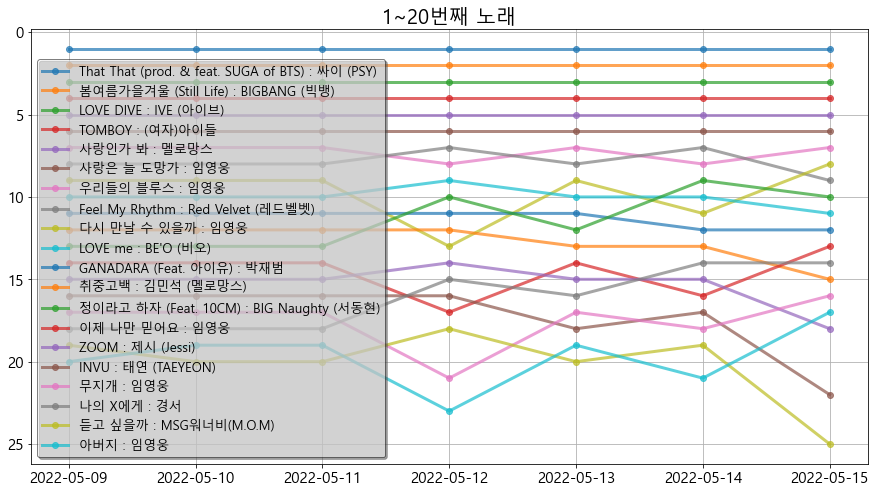

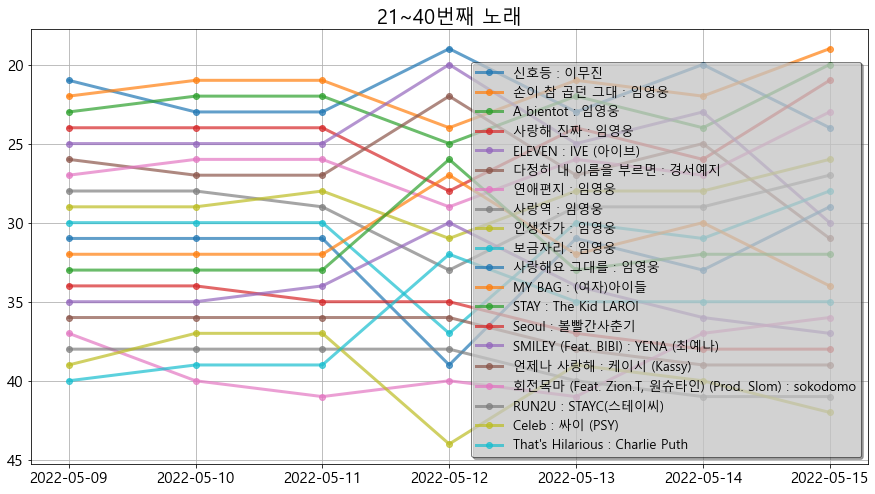

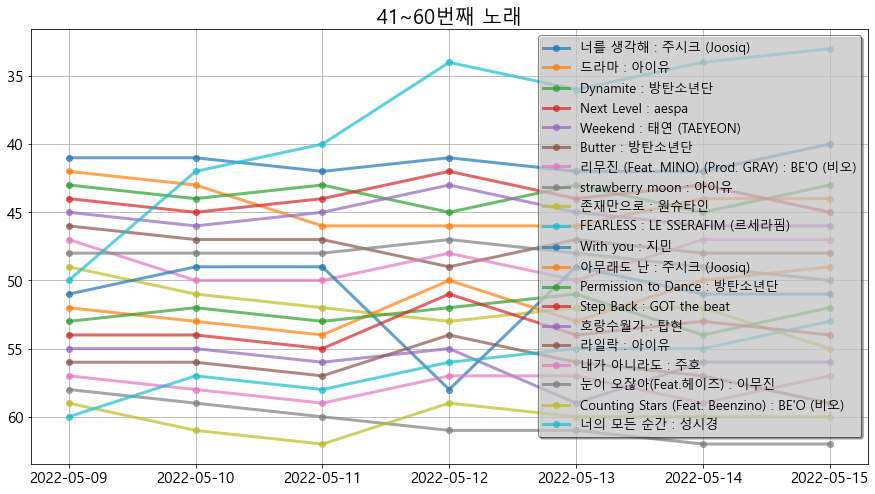

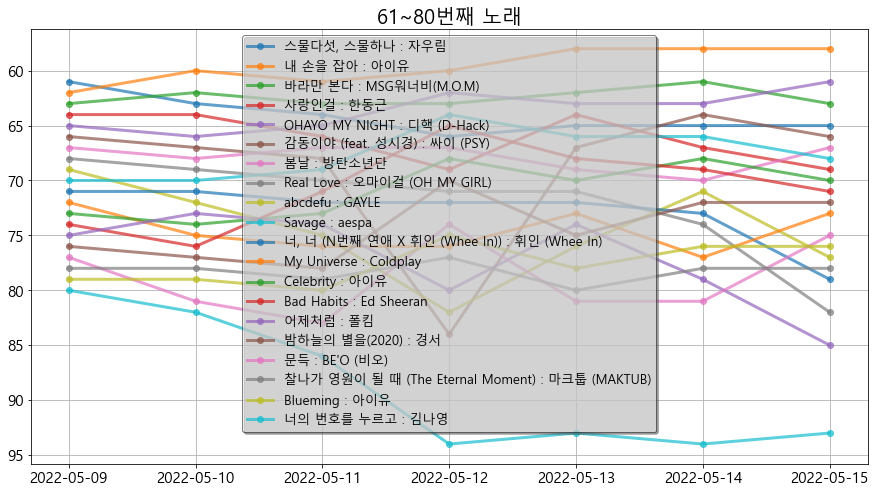

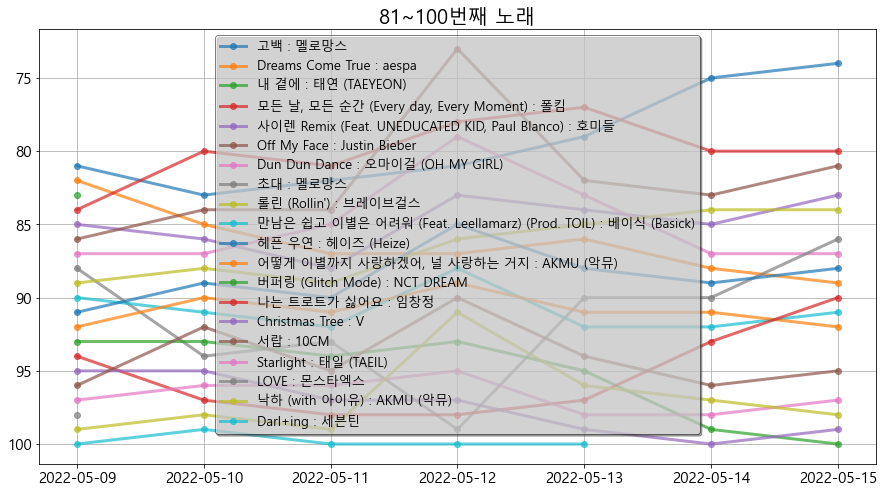

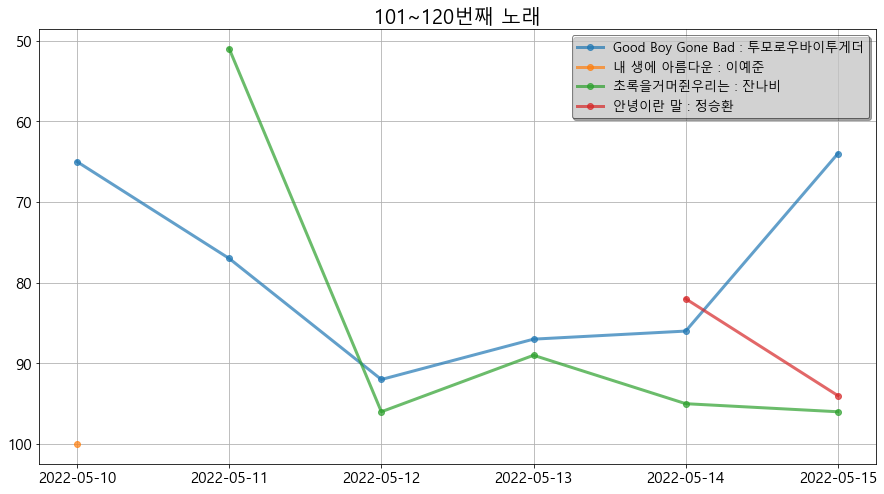

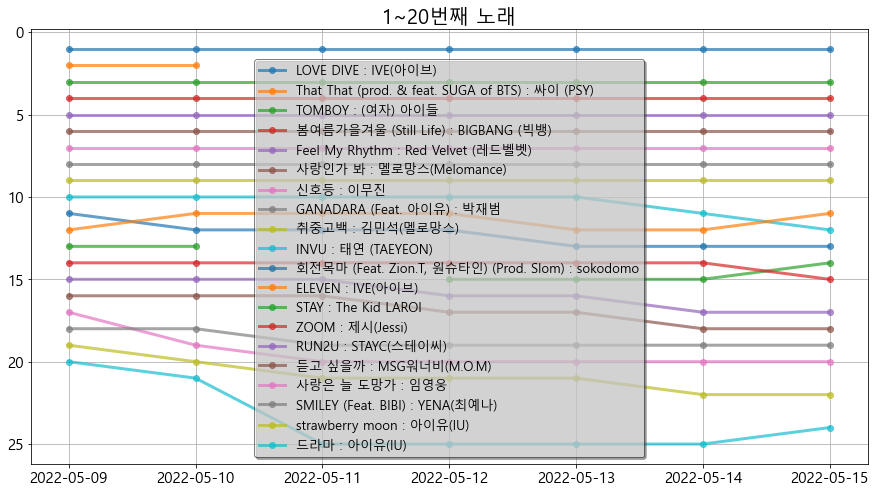

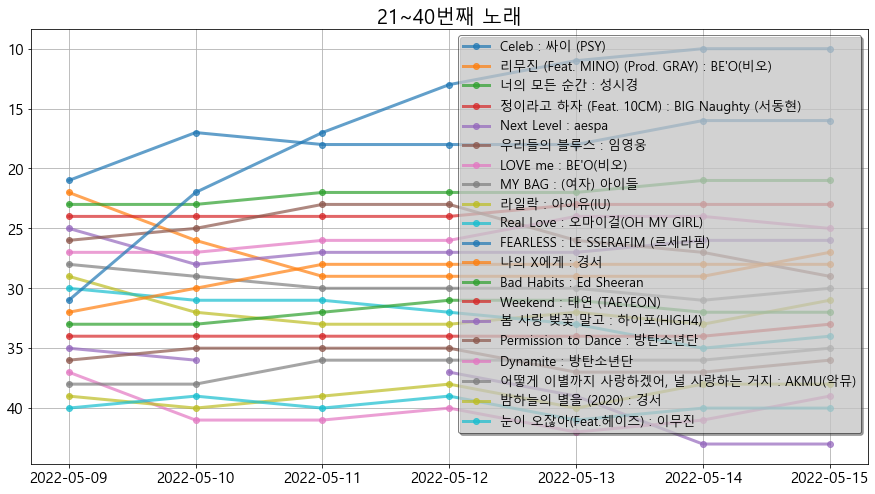

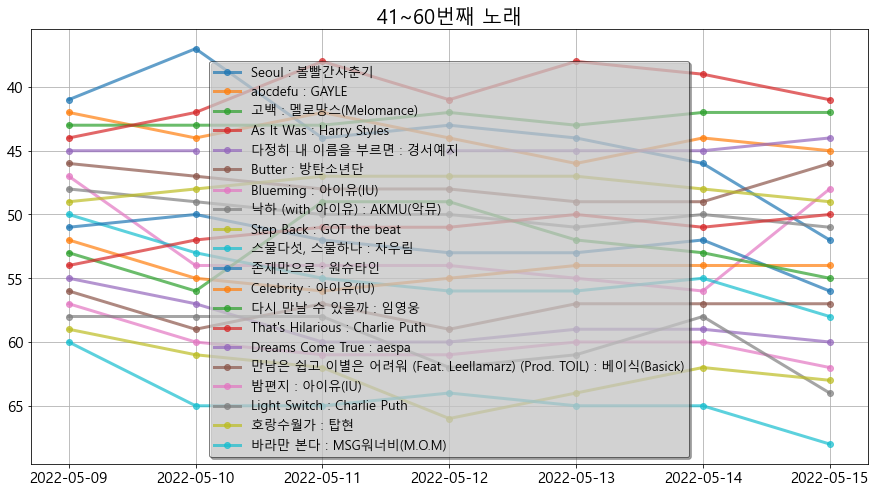

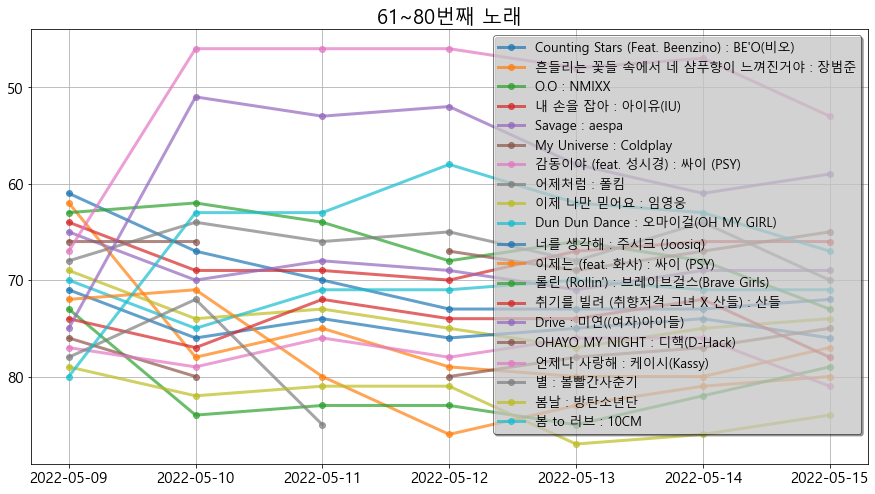

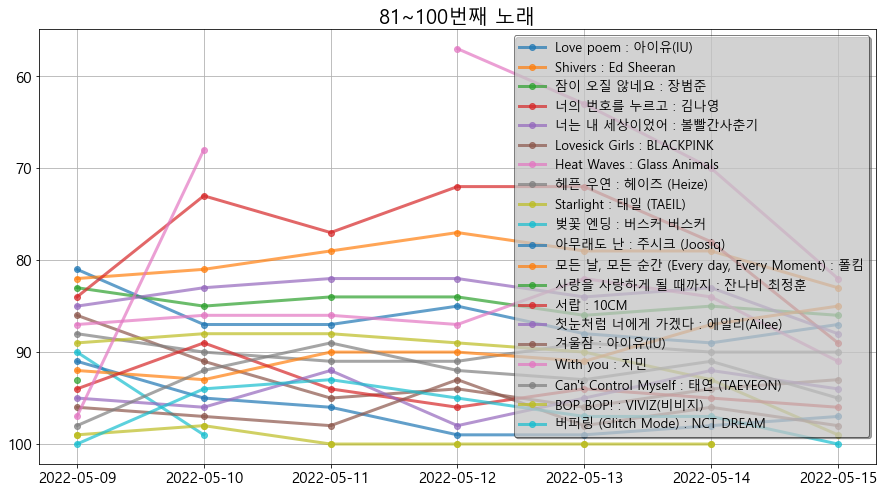

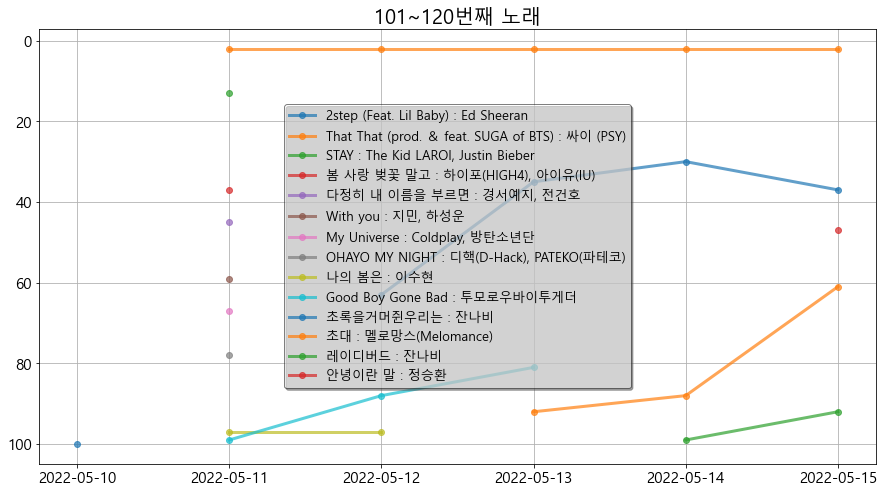

In [487]:
# 음원 사이트
site_list = ['flo', 'bugs', 'genie', 'melon', 'vibe']
total_outlier_df = pd.DataFrame()
for site_name in site_list:
    # 실시간 순위 파일 폴더로 이동
    live_folder = f'/crawled_data/mod_{site_name}/'
    try:
        os.chdir(code_path + live_folder)
    except:
        pass
    file_list = os.listdir()

    df = pd.DataFrame()
    for one in file_list:
        temp = pd.read_excel(one)
        df = pd.concat([df, temp], ignore_index=True)
    df['날짜'] = df['날짜'].astype(str)
    sliced_df = df[(df['날짜'] >= start_date) & (df['날짜'] <= end_date)].reset_index(drop=True)
    # 이번주 날짜 df
    dates = pd.date_range(start_date, end_date)
    basic_date_df = pd.DataFrame({'날짜':dates})
    basic_date_df['날짜'] = basic_date_df['날짜'].astype('str')
    # 음원의 유일한 곡, 가수 명 남기기
    unique_sliced_df = sliced_df.drop_duplicates(['곡', '가수']).reset_index(drop=True)
    # 음원별 순위변동 추가 df
    song_df_list = []
    for i in range(unique_sliced_df.shape[0]):
        temp = unique_sliced_df.iloc[i:i+1, :].reset_index(drop=True)
        one_df = sliced_df[(sliced_df['곡'] == temp['곡'][0]) & (sliced_df['가수'] == temp['가수'][0])].reset_index(drop=True)
        one_df['순위변동'] = - ( one_df['순위'] - one_df['순위'].shift(1) )
        one_df['순위변동'] = one_df['순위변동'].fillna(0)
        one_df['순위변동'] = one_df['순위변동'].astype('int64')
        merged_df = pd.merge(basic_date_df, one_df, how='left', on='날짜')
        site = merged_df['사이트'].value_counts().index[0]
        title = merged_df['곡'].value_counts().index[0]
        artist = merged_df['가수'].value_counts().index[0]
        album = merged_df['앨범'].value_counts().index[0]
        agency = merged_df['소속사'].value_counts().index[0]
        agency_type = merged_df['소속사_분류'].value_counts().index[0]
        merged_df['사이트'] = merged_df['사이트'].fillna(site)
        merged_df['곡'] = merged_df['곡'].fillna(title)
        merged_df['가수'] = merged_df['가수'].fillna(artist)
        merged_df['앨범'] = merged_df['앨범'].fillna(album)
        merged_df['소속사'] = merged_df['소속사'].fillna(agency)
        merged_df['소속사_분류'] = merged_df['소속사_분류'].fillna(agency_type)
        song_df_list.append(merged_df)
    # 그래프 저장할 폴더
    save_folder = f'/crawled_data/outlier_data/{start_date}_{end_date}/{site_name}/'
    # 그래프 출력
    number = 20
    t = 0
    for i in range( math.ceil(len(song_df_list)/number) ):
        plt.figure( figsize=(15, 8) )
        ax = plt.axes()
        ax.invert_yaxis()
        graph_df = song_df_list[i*number:(i+1)*number]
        for one in graph_df:
            title = one['곡'].value_counts().index.values[0]
            artist = one['가수'].value_counts().index.values[0]
            song_label = title + ' : ' + artist
            plt.plot(one['날짜'], one['순위'], '-o', label=song_label, linewidth=3, alpha=0.7)
        t =  t + number
        plt.grid(True)
        plt.title(f'{t-(number-1)}~{t}번째 노래', fontdict={'size':20})
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.legend(framealpha=0.5, fontsize=13, frameon=True, edgecolor='k', shadow=True);
        plt.savefig(code_path + save_folder + f'{start_date}_{end_date}_그래프{t:0>2}.png')

    # 이번주 모든 노래 데이터 병합
    total_df = pd.DataFrame()
    for one in song_df_list:
        total_df = pd.concat([total_df, one], ignore_index=True)
    # 음원의 유일한 곡, 가수만 남기기
    unique_music_df = total_df.sort_values(['사이트', '곡', '가수', '순위']).reset_index(drop=True).drop_duplicates(['곡', '가수'], ignore_index=True)
    # 해당 음원의 순위변동이 양수인 df 추출
    mean_unique_music_df = pd.DataFrame()
    for i in range(unique_music_df.shape[0]):
        title = unique_music_df['곡'][i]
        artist = unique_music_df['가수'][i]
        temp = total_df[ (total_df['곡'] == title) & (total_df['가수'] == artist) & (total_df['순위변동'] > 0)].reset_index(drop=True)
        # 해당 음원의 순위변동평균
        temp['순위변동평균(양수)'] = round( temp['순위변동'].mean(), 1 )
        # 해당 음원 df의 첫째 줄만 추출
        first_temp = temp.iloc[0:1, :]
        mean_unique_music_df = pd.concat([mean_unique_music_df, first_temp], ignore_index=True)
    # 급등 음원 추출
    u_outlier = 30
    outlier_df = mean_unique_music_df[mean_unique_music_df['순위변동평균(양수)'] > u_outlier].reset_index(drop=True)
    # 파일 저장할 폴더 생성
    mod_start_date = start_date.replace('-','')
    mod_end_date = end_date.replace('-','')
    path = f'C:/data/Wantreez/Crawling/music/crawled_data/outlier_data/{start_date}_{end_date}/{site_name}/'
    os.makedirs(path, exist_ok=True)
    # 이상치 음원 평균 df 출력
    outlier_df.to_excel(path + f'[{site_name}]{mod_start_date}_{mod_end_date}_mean_outliers.xlsx', index=False)
    print(f'[{site_name}]{mod_start_date}_{mod_end_date}_mean_outliers.xlsx 출력')
    # 이상치 음원 df 종합
    total_outlier_df = pd.concat([total_outlier_df, outlier_df], ignore_index=True)

## 이상치 곡 종합

In [488]:
total_outlier_df

날짜    사이트    순위                               곡            가수  \
0   2022-05-11   Bugs  63.0                        Dynamite         방탄소년단   
1   2022-05-13   Bugs  38.0           forEVER (feat. TABLO)      싸이 (PSY)   
2   2022-05-12   Bugs  33.0                             꽃 길  BIGBANG (빅뱅)   
3   2022-05-11   Bugs  44.0                        너의 모든 순간           성시경   
4   2022-05-14   Bugs  62.0                      너의 번호를 누르고           김나영   
5   2022-05-10   Bugs  17.0                     다시 만날 수 있을까           임영웅   
6   2022-05-13   Bugs  21.0                           레이디버드           잔나비   
7   2022-05-10   Bugs  47.0                             무지개           임영웅   
8   2022-05-10   Bugs  50.0                      손이 참 곱던 그대           임영웅   
9   2022-05-13   Bugs  10.0                          슬픔이여안녕           잔나비   
10  2022-05-10   Bugs  48.0                            어제처럼  폴킴(Paul Kim)   
11  2022-05-12   Bugs  78.0                         언제나 사랑해           케이시   
12  2022-05-13  Genie  56.0  에잇 (Prod. & Feat. SUGA of BTS)      아이유 (IU)   

                                   앨범           소속사 소속사_분류  순위변동  순위변동평균(양수)  
0          Dynamite (DayTime Version)           빅히트    빅히트  27.0        34.3  
1                                 싸다9      P NATION     기타  42.0        42.0  
2                                 꽃 길            YG     YG  61.0        61.0  
3   별에서 온 그대 (SBS 수목드라마) OST - Part.7           SSK     기타  54.0        51.0  
4                          너의 번호를 누르고          플렉스엠     기타  35.0        35.0  
5                             IM HERO         물고기뮤직     기타  49.0        50.0  
6              잔나비 소곡집 ll : 초록을거머쥔우리는         페포니뮤직     기타  54.0        54.0  
7                             IM HERO         물고기뮤직     기타  34.0        34.0  
8                             IM HERO         물고기뮤직     기타  48.0        48.0  
9              잔나비 소곡집 ll : 초록을거머쥔우리는         페포니뮤직     기타  38.0        38.0  
10                               어제처럼  neuron music     기타  26.0        31.0  
11               조영수 리메이크 프로젝트 Part.2        NEXTAR     기타  18.0        30.5  
12                                 에잇          EDAM     기타  35.0        35.0

In [489]:
idx = total_outlier_df[total_outlier_df['소속사'] == '해외'].index
idx

Int64Index([], dtype='int64')

In [493]:
mod_total_outlier_df = total_outlier_df.drop(idx).reset_index(drop=True)
mod_total_outlier_df = mod_total_outlier_df[['날짜', '순위변동평균(양수)', '곡', '가수', '소속사', '순위', '앨범', '소속사_분류', '순위변동', '사이트']]
mod_total_outlier_df

날짜  순위변동평균(양수)                               곡            가수  \
0   2022-05-11        34.3                        Dynamite         방탄소년단   
1   2022-05-13        42.0           forEVER (feat. TABLO)      싸이 (PSY)   
2   2022-05-12        61.0                             꽃 길  BIGBANG (빅뱅)   
3   2022-05-11        51.0                        너의 모든 순간           성시경   
4   2022-05-14        35.0                      너의 번호를 누르고           김나영   
5   2022-05-10        50.0                     다시 만날 수 있을까           임영웅   
6   2022-05-13        54.0                           레이디버드           잔나비   
7   2022-05-10        34.0                             무지개           임영웅   
8   2022-05-10        48.0                      손이 참 곱던 그대           임영웅   
9   2022-05-13        38.0                          슬픔이여안녕           잔나비   
10  2022-05-10        31.0                            어제처럼  폴킴(Paul Kim)   
11  2022-05-12        30.5                         언제나 사랑해           케이시   
12  2022-05-13        35.0  에잇 (Prod. & Feat. SUGA of BTS)      아이유 (IU)   

             소속사    순위                                 앨범 소속사_분류  순위변동    사이트  
0            빅히트  63.0         Dynamite (DayTime Version)    빅히트  27.0   Bugs  
1       P NATION  38.0                                싸다9     기타  42.0   Bugs  
2             YG  33.0                                꽃 길     YG  61.0   Bugs  
3            SSK  44.0  별에서 온 그대 (SBS 수목드라마) OST - Part.7     기타  54.0   Bugs  
4           플렉스엠  62.0                         너의 번호를 누르고     기타  35.0   Bugs  
5          물고기뮤직  17.0                            IM HERO     기타  49.0   Bugs  
6          페포니뮤직  21.0             잔나비 소곡집 ll : 초록을거머쥔우리는     기타  54.0   Bugs  
7          물고기뮤직  47.0                            IM HERO     기타  34.0   Bugs  
8          물고기뮤직  50.0                            IM HERO     기타  48.0   Bugs  
9          페포니뮤직  10.0             잔나비 소곡집 ll : 초록을거머쥔우리는     기타  38.0   Bugs  
10  neuron music  48.0                               어제처럼     기타  26.0   Bugs  
11        NEXTAR  78.0               조영수 리메이크 프로젝트 Part.2     기타  18.0   Bugs  
12          EDAM  56.0                                 에잇     기타  35.0  Genie

### 이상치 음원 df 출력

In [494]:
save_total_oulier_df_path = f'/crawled_data/outlier_data/{start_date}_{end_date}/'
code_path + save_total_oulier_df_path

'c:/data/Wantreez/Crawling/music/crawled_data/outlier_data/2022-05-09_2022-05-15/'

In [495]:
mod_total_outlier_df.to_excel(code_path + save_total_oulier_df_path + f'{start_date}_{end_date}_total_outlier.xlsx', index=False)
print(f'{start_date}_{end_date}_total_outlier.xlsx 출력')

2022-05-09_2022-05-15_total_outlier.xlsx 출력


### 이상치 음원 순위변동 평균 그래프(3-1-1. 순위 급상승 음원)

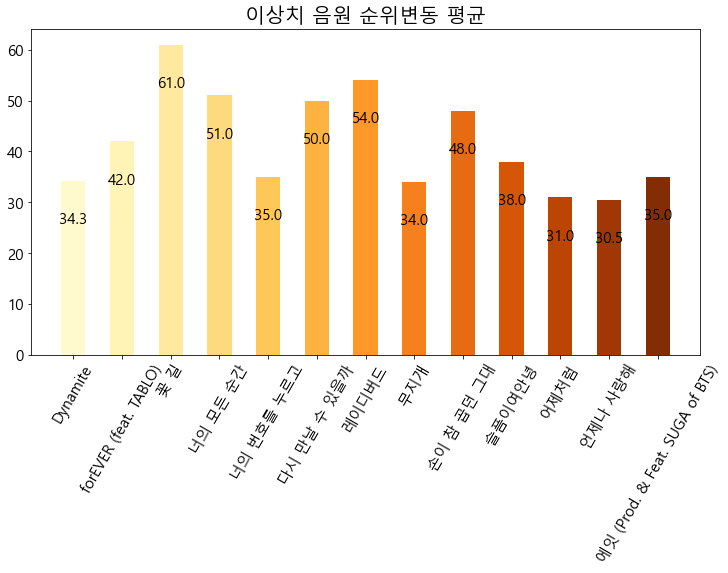

In [496]:
plt.figure(figsize=(12, 6))
colors = sns.color_palette('YlOrBr', mod_total_outlier_df.shape[0])
plt.bar('곡', '순위변동평균(양수)', data=mod_total_outlier_df, color=colors, width=0.5)
plt.title(f'이상치 음원 순위변동 평균', fontdict={'size':20})
for i in range(mod_total_outlier_df.shape[0]):
    plt.text(i, mod_total_outlier_df['순위변동평균(양수)'][i] - mod_total_outlier_df['순위변동평균(양수)'].max()*0.1, round(mod_total_outlier_df['순위변동평균(양수)'][i], 1), verticalalignment='top', horizontalalignment='center', fontsize=15)
plt.xticks(fontsize=15, rotation=60)
plt.yticks(fontsize=15);
plt.savefig(code_path + save_total_oulier_df_path + f'{start_date}_{end_date}_total_outlier.png')

### 이상치 음원들의 평균 순위(4-2-1. 소속사별 진입 음원)

In [497]:
# 음원 사이트
site_list = ['flo', 'bugs', 'genie', 'melon', 'vibe']
outlier_agency_df = pd.DataFrame()
for site_name in site_list:
    # 실시간 순위 파일 폴더로 이동
    live_folder = f'/crawled_data/mod_{site_name}/'
    try:
        os.chdir(code_path + live_folder)
    except:
        pass
    file_list = os.listdir()

    df = pd.DataFrame()
    for one in file_list:
        temp = pd.read_excel(one)
        df = pd.concat([df, temp], ignore_index=True)
    df['날짜'] = df['날짜'].astype(str)
    sliced_df = df[(df['날짜'] >= start_date) & (df['날짜'] <= end_date)].reset_index(drop=True)
 
    # 이상치 음원의 기획사 소속 가수 평균
    for agency in mod_total_outlier_df['소속사'].unique():
        temp = sliced_df[sliced_df['소속사'] == agency].reset_index(drop=True)
        outlier_agency_df = pd.concat([outlier_agency_df, temp], ignore_index=True)

In [498]:
outlier_agency_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   사이트     1313 non-null   object
 1   날짜      1313 non-null   object
 2   순위      1313 non-null   int64 
 3   곡       1313 non-null   object
 4   가수      1313 non-null   object
 5   앨범      1313 non-null   object
 6   소속사     1313 non-null   object
 7   소속사_분류  1313 non-null   object
dtypes: int64(1), object(7)
memory usage: 82.2+ KB


In [499]:
mean_outlier_agency_df = outlier_agency_df.groupby(['소속사', '사이트', '곡', '가수']).agg({'순위':'mean'}).reset_index()

In [500]:
mean_outlier_agency_df = mean_outlier_agency_df.rename(columns={'순위':'순위평균'})
mean_outlier_agency_df = mean_outlier_agency_df[['소속사', '곡', '가수', '순위평균', '사이트']]
mean_outlier_agency_df['순위평균'] = round(mean_outlier_agency_df['순위평균'], 1)

In [501]:
mean_outlier_agency_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   소속사     228 non-null    object 
 1   곡       228 non-null    object 
 2   가수      228 non-null    object 
 3   순위평균    228 non-null    float64
 4   사이트     228 non-null    object 
dtypes: float64(1), object(4)
memory usage: 9.0+ KB


In [502]:
mean_outlier_agency_df.head()

소속사                곡       가수  순위평균   사이트
0  EDAM         Blueming  아이유(IU)  86.8  Bugs
1  EDAM        Celebrity  아이유(IU)  82.0  Bugs
2  EDAM  strawberry moon  아이유(IU)  52.0  Bugs
3  EDAM          내 손을 잡아  아이유(IU)  75.0  Bugs
4  EDAM              드라마  아이유(IU)  43.7  Bugs

In [503]:
# 이상치 음원 소속사 음원 순위 평균 df 출력
mean_outlier_agency_df.to_excel(code_path + save_total_oulier_df_path + f'{start_date}_{end_date}_mean_outlier_agency.xlsx', index=False)
print(f'{start_date}_{end_date}_mean_outlier_agency.xlsx 출력')

2022-05-09_2022-05-15_mean_outlier_agency.xlsx 출력


### 이상치 음원 기획사별 분석(4-1-1. 기획사별 음원차트 진입 요약)

In [507]:
agency_music_df = mean_outlier_agency_df.drop_duplicates(['소속사', '곡', '가수']).reset_index(drop=True)
agency_music_df

소속사                곡       가수  순위평균    사이트
0     EDAM         Blueming  아이유(IU)  86.8   Bugs
1     EDAM        Celebrity  아이유(IU)  82.0   Bugs
2     EDAM  strawberry moon  아이유(IU)  52.0   Bugs
3     EDAM          내 손을 잡아  아이유(IU)  75.0   Bugs
4     EDAM              드라마  아이유(IU)  43.7   Bugs
..     ...              ...      ...   ...    ...
107  페포니뮤직           슬픔이여안녕      잔나비  32.0   Bugs
108  페포니뮤직       여름가을겨울  봄.      잔나비  16.8   Bugs
109  페포니뮤직        초록을거머쥔우리는      잔나비   3.0   Bugs
110  페포니뮤직        여름가을겨울 봄.      잔나비  84.0  Genie
111   플렉스엠       너의 번호를 누르고      김나영  81.7   Bugs

[112 rows x 5 columns]

In [508]:
agency_music_df.groupby(['소속사']).agg('size').reset_index()

소속사   0
0          EDAM  27
1        NEXTAR   3
2      P NATION  29
3           SSK   2
4            YG  15
5  neuron music   4
6         물고기뮤직  14
7           빅히트  12
8         페포니뮤직   5
9          플렉스엠   1

In [509]:
mean_outlier_agency_df.groupby(['소속사']).agg('size').reset_index()

소속사   0
0          EDAM  40
1        NEXTAR   5
2      P NATION  45
3           SSK   6
4            YG  23
5  neuron music   9
6         물고기뮤직  54
7           빅히트  32
8         페포니뮤직  11
9          플렉스엠   3

In [510]:
num_music = mean_outlier_agency_df.groupby(['소속사']).agg('size').reset_index().sort_values(0, ascending=False)
num_music.columns = ['소속사', '음원수량']
num_music

소속사  음원수량
6         물고기뮤직    54
2      P NATION    45
0          EDAM    40
7           빅히트    32
4            YG    23
8         페포니뮤직    11
5  neuron music     9
3           SSK     6
1        NEXTAR     5
9          플렉스엠     3

In [511]:
num_music_df = pd.merge(mean_outlier_agency_df, num_music, how='left', on='소속사')
num_music_df.head()

소속사                곡       가수  순위평균   사이트  음원수량
0  EDAM         Blueming  아이유(IU)  86.8  Bugs    40
1  EDAM        Celebrity  아이유(IU)  82.0  Bugs    40
2  EDAM  strawberry moon  아이유(IU)  52.0  Bugs    40
3  EDAM          내 손을 잡아  아이유(IU)  75.0  Bugs    40
4  EDAM              드라마  아이유(IU)  43.7  Bugs    40

In [512]:
max_num_music = num_music_df.sort_values(['음원수량', '순위평균'], ascending=False).iloc[0:1, :]
max_num_music

소속사           곡   가수  순위평균   사이트  음원수량
133  물고기뮤직  손이 참 곱던 그대  임영웅  82.3  Bugs    54

In [513]:
max_rank_music = num_music_df.sort_values('순위평균', ascending=True).iloc[0:1, :]
max_rank_music

소속사                                      곡        가수  순위평균    사이트  \
79  P NATION  That That (prod. & feat. SUGA of BTS)  싸이 (PSY)   1.0  Melon   

    음원수량  
79    45

In [516]:
agency_in_chart = pd.concat([max_num_music, max_rank_music], ignore_index=True)
agency_in_chart = agency_in_chart[['소속사', '음원수량', '순위평균', '가수', '곡', '사이트']]
agency_in_chart

소속사  음원수량  순위평균        가수                                      곡  \
0     물고기뮤직    54  82.3       임영웅                             손이 참 곱던 그대   
1  P NATION    45   1.0  싸이 (PSY)  That That (prod. & feat. SUGA of BTS)   

     사이트  
0   Bugs  
1  Melon

In [517]:
# 이상치 음원 소속사별 음원차트 진입 요약 df 출력
agency_in_chart.to_excel(code_path + save_total_oulier_df_path + f'{start_date}_{end_date}_agency_in_chart.xlsx', index=False)
print(f'{start_date}_{end_date}_agency_in_chart.xlsx 출력')

2022-05-09_2022-05-15_agency_in_chart.xlsx 출력


## 4-1-2. 기획사 소셜미디어 관심도 요약

In [518]:
# 파일 저장 폴더 생성
naver_datalab_path = f'/crawled_data/outlier_data/{start_date}_{end_date}/naver_datalab/'
des2 = code_path + naver_datalab_path
os.makedirs(des2, exist_ok=True)
des2

'c:/data/Wantreez/Crawling/music/crawled_data/outlier_data/2022-05-09_2022-05-15/naver_datalab/'

In [524]:
ca.install(True)
driver = webdriver.Chrome()

In [525]:
# 네이버 데이터 랩 검색
for i in range(agency_in_chart.shape[0]):
    # 네이버 데이터 랩 접속
    url = 'https://datalab.naver.com/keyword/trendSearch.naver'
    driver.get(url)
    driver.implicitly_wait(3)
    time.sleep( random.uniform(1, 1.5) )
    driver.maximize_window()

    # 검색어 입력
    word = agency_in_chart['소속사'][i]
    search_box = driver.find_element_by_xpath('/html/body/div[2]/div[2]/div[1]/div/div[2]/div[1]/div/form/fieldset/div/div[1]/div[1]/input')
    search_box.clear()
    time.sleep( random.uniform(1, 1.5) )
    search_box.send_keys(word)

    # 3개월 picker 클릭
    time_picker = driver.find_element_by_xpath('/html/body/div[2]/div[2]/div[1]/div/div[2]/div[1]/div/form/fieldset/div/div[6]/div[1]/label[3]').click()
    time.sleep( random.uniform(1, 1.5) )

    # 주간 클릭
    week_picker = driver.find_element_by_xpath('/html/body/div[2]/div[2]/div[1]/div/div[2]/div[1]/div/form/fieldset/div/div[6]/div[1]/div').click()
    time.sleep( random.uniform(0.5, 1) )
    week_button = driver.find_element_by_xpath('/html/body/div[2]/div[2]/div[1]/div/div[2]/div[1]/div/form/fieldset/div/div[6]/div[1]/div/ul/li[2]').click()
    time.sleep( random.uniform(0.5, 1) )

    # 검색 버튼 클릭
    search_button = driver.find_element_by_xpath('/html/body/div[2]/div[2]/div[1]/div/div[2]/div[1]/div/form/fieldset/a/span').click()
    time.sleep( random.uniform(1, 1.5) )
    driver.implicitly_wait(3)

    # 다운 버튼 클릭
    down_button = driver.find_element_by_xpath('/html/body/div[2]/div[2]/div/div[1]/div[1]/div[1]/div/div/div/div/div/div[1]/div[4]/a').click()
    time.sleep( random.uniform(1, 1.5) )

    # 파일 이름 변경
    down_folder = 'C:/Users/kbjung/Downloads/'
    down_xlsx = 'datalab.xlsx'

    new_down_xlsx = f'{word}.xlsx'
    os.rename(down_folder + down_xlsx, down_folder + new_down_xlsx)

    # 파일 이동
    shutil.move(down_folder + new_down_xlsx, des2 + new_down_xlsx)
    print(f'{new_down_xlsx} 완료.')

C:\Users\kbjung\AppData\Local\Temp/ipykernel_15120/2510828449.py:12: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  search_box = driver.find_element_by_xpath('/html/body/div[2]/div[2]/div[1]/div/div[2]/div[1]/div/form/fieldset/div/div[1]/div[1]/input')
C:\Users\kbjung\AppData\Local\Temp/ipykernel_15120/2510828449.py:18: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  time_picker = driver.find_element_by_xpath('/html/body/div[2]/div[2]/div[1]/div/div[2]/div[1]/div/form/fieldset/div/div[6]/div[1]/label[3]').click()
C:\Users\kbjung\AppData\Local\Temp/ipykernel_15120/2510828449.py:22: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  week_picker = driver.find_element_by_xpath('/html/body/div[2]/div[2]/div[1]/div/div[2]/div[1]/div/form/fieldset/div/div[6]/div[1]/div').click()
C:\Users\kbj

물고기뮤직.xlsx 완료.
P NATION.xlsx 완료.


In [526]:
driver.quit()

## 그래프(음원 순위 변동 사항 대비 소셜미디어내 관심도 추이)

In [532]:
xticks_names = ['5월1주차', '5월2주차']

In [535]:
des2

'c:/data/Wantreez/Crawling/music/crawled_data/outlier_data/2022-05-09_2022-05-15/naver_datalab/'

In [527]:
file_list = os.listdir(des2)
file_list

['ky', 'P NATION.xlsx', 'tj', '물고기뮤직.xlsx', '음원 사재기.png', '음원 사재기.xlsx']

In [530]:
agency_in_chart['소속사'].values

array(['물고기뮤직', 'P NATION'], dtype=object)

In [531]:
agency_in_chart['소속사'].values[0]

'물고기뮤직'

In [529]:
'물고기뮤직' in agency_in_chart['소속사'].values

True

In [554]:
'P NATION' in agency_in_chart['소속사'].values

True

소속사_소셜관심도.png 저장 완료.


C:\Users\kbjung\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\kbjung\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


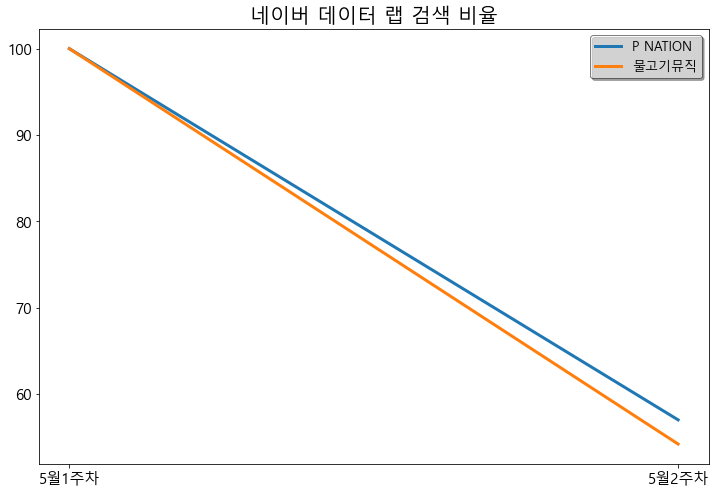

In [557]:
# 그래프 생성
file_list = os.listdir(des2)
plt.figure( figsize=(12,8) )
for one in file_list:
    title = one.split('.')[0]
    if title in agency_in_chart['소속사'].values:
        # print(title)
        temp = pd.read_excel(des2 + one)
        temp = temp.reset_index(drop=True)
        temp = temp.iloc[6:, :].reset_index(drop=True)
        temp.columns = ['날짜', '검색비율']

        date_list = pd.date_range(end=start_date, periods=2, freq='W-MON')
        start_week = str(date_list[0]).split(' ')[0]
        end_week = str(date_list[-1]).split(' ')[0]
        week_temp = temp[ (temp['날짜'] >= start_week) & (temp['날짜'] <= end_week)].reset_index(drop=True)
        week_temp['검색비율'] = week_temp['검색비율'].astype(float)
        week_temp['검색비율'] = round(week_temp['검색비율'], 1)
        
        x = xticks_names
        y = week_temp['검색비율']

        plt.plot(x, y, linewidth=3, label=title)

plt.title(f"네이버 데이터 랩 검색 비율", fontsize=20)
plt.xticks(xticks_names ,fontsize=15)
plt.yticks(fontsize=15)
plt.legend(framealpha=0.5, fontsize=13, frameon=True, edgecolor='k', shadow=True);
plt.savefig(des2 + '소속사_소셜관심도.png')
print('소속사_소셜관심도.png 저장 완료.')

# 코드 마지막